<a href="https://colab.research.google.com/github/ShaliniAnandaPhD/PIXEL-PIONEERS-TUTORIALS/blob/main/BIOPRINTING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gym
!pip install stable-baselines3[extra]
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.1/182.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 45.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.

In [ ]:
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import PPO

In [ ]:
  import gym
from gym import spaces
import numpy as np
from stable_baselines3 import PPO

class BioprintEnv(gym.Env):
    def __init__(self):
        super(BioprintEnv, self).__init__()

        # Define the observation space
        self.observation_space = spaces.Box(low=0, high=1.0, shape=(128, 128, 128), dtype=np.float32)

        # Define the action space
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(6,), dtype=np.float32)

        # Initialize the current step
        self.current_step = 0

        # Define the maximum number of steps per episode
        self.max_steps = 100

        # Initialize the bioprinting environment
        self.bioprint_env = self.initialize_bioprint_env()

        # Define the target organ geometry
        self.target_geometry = self.define_target_geometry()

        # Define the target organ functional metrics
        self.target_function = self.define_target_function()

        # Define the print head parameters
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        self.material_deposition_rate = 0.1

    def initialize_bioprint_env(self):
        # Initialize the bioprinting environment
        # Set up the initial state, geometry, materials, etc.
        initial_state = np.zeros((128, 128, 128), dtype=np.float32)
        return initial_state

    def define_target_geometry(self):
        # Define the target organ geometry
        # Create a 3D array representing the desired shape of the organ
        target_geometry = np.zeros((128, 128, 128), dtype=np.float32)
        # Add desired geometric features
        target_geometry[50:80, 50:80, 50:80] = 1.0
        return target_geometry

    def define_target_function(self):
        # Define the target organ functional metrics
        # Set the desired functional parameters, e.g., porosity, elasticity, etc.
        target_function = {'porosity': 0.8, 'elasticity': 0.9}
        return target_function

    def step(self, action):
        # Apply the action to the bioprinting environment
        self.apply_action(action)

        # Simulate the bioprinting process
        self.simulate_bioprinting()

        # Get the current observation
        observation = self.get_observation()

        # Calculate the reward
        reward = self.calculate_reward(observation)

        # Increment the current step
        self.current_step += 1

        # Check if the episode is done
        done = (self.current_step >= self.max_steps)

        # Create an info dictionary
        info = {}

        return observation, reward, done, info

    def apply_action(self, action):
        # Apply the action to the bioprinting environment
        # Adjust print head position and velocity based on action
        self.print_head_position += action[:3] * 0.1
        self.print_head_velocity = action[3:] * 10.0

        # Clip print head position to stay within the boundaries
        self.print_head_position = np.clip(self.print_head_position, 0, 127)

    def simulate_bioprinting(self):
        # Simulate the bioprinting process
        # Update the bioprinting environment based on the print head position and velocity

        # Calculate the deposition location based on print head position
        deposition_location = self.print_head_position.astype(int)

        # Calculate the deposition amount based on material deposition rate and print head velocity
        deposition_amount = self.material_deposition_rate * np.linalg.norm(self.print_head_velocity)

        # Update the bioprinting environment at the deposition location
        self.bioprint_env[deposition_location[0], deposition_location[1], deposition_location[2]] += deposition_amount

        # Clip the bioprinting environment values to stay within the valid range
        self.bioprint_env = np.clip(self.bioprint_env, 0, 1)

    def get_observation(self):
        # Get the current observation of the bioprinting environment
        observation = self.bioprint_env
        return observation

    def calculate_reward(self, observation):
        # Calculate the reward based on the current observation and target geometry/function

        # Compare the current geometry with the target geometry
        geometry_similarity = np.sum(observation == self.target_geometry) / np.prod(observation.shape)

        # Evaluate the current functional metrics
        porosity = np.mean(observation < 0.5)
        elasticity = np.mean(observation)

        # Calculate the reward based on geometry similarity and functional metrics
        reward = geometry_similarity + (porosity - self.target_function['porosity'])**2 + (elasticity - self.target_function['elasticity'])**2
        reward = -reward  # Negating the reward to minimize the difference from target metrics

        return reward

    def reset(self):
        # Reset the bioprinting environment to its initial state
        self.bioprint_env = self.initialize_bioprint_env()

        # Reset the current step
        self.current_step = 0

        # Reset the print head position and velocity
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)

        # Return the initial observation
        return self.get_observation()

    def render(self, mode='human'):
        # Render the bioprinting environment
        # Placeholder for rendering functionality
        pass

def evaluate_model(model, env, num_episodes):
    # Evaluate the model for a given number of episodes

    total_reward = 0
    for _ in range(num_episodes):
        obs = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward

    mean_reward = total_reward / num_episodes
    return mean_reward

# Create the bioprinting environment
env = BioprintEnv()

# Create the PPO model
model = PPO("MlpPolicy", env, verbose=1)

# Set up the training loop
total_timesteps = 100000  # Total number of training timesteps
checkpoint_interval = 10000  # Interval for saving model checkpoints

# Training loop
for i in range(total_timesteps // checkpoint_interval):
    # Train the model for checkpoint_interval timesteps
    model.learn(total_timesteps=checkpoint_interval)

    # Save the model checkpoint
    model.save(f"bioprint_model_{(i+1)*checkpoint_interval}_steps")

    # Evaluate the model
    mean_reward = evaluate_model(model, env, num_episodes=10)
    print(f"Mean reward at step {(i+1)*checkpoint_interval}: {mean_reward:.2f}")

    # Monitor training progress and debug issues
    if mean_reward < -10:
        print("Warning: Mean reward is very low. Debugging...")
        # Add debugging code here to investigate the issue
        # For example, you can inspect the environment state, action distribution, or model parameters
        # You can also add logging statements or use a debugger to step through the code

    if (i+1) % 10 == 0:
        print(f"Completed {(i+1)*checkpoint_interval} training steps.")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -184     |
| time/              |          |
|    fps             | 42       |
|    iterations      | 1        |
|    time_elapsed    | 47       |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -184         |
| time/                   |              |
|    fps                  | 20           |
|    iterations           | 2            |
|    time_elapsed         | 198          |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0009195604 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    e

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 60.2     |
| time/              |          |
|    fps             | 96       |
|    iterations      | 1        |
|    time_elapsed    | 21       |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50           |
|    ep_rew_mean          | 60.2         |
| time/                   |              |
|    fps                  | 53           |
|    iterations           | 2            |
|    time_elapsed         | 76           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0057038385 |
|    clip_fraction        | 0.0212       |
|    clip_range           | 0.2          |
|    e

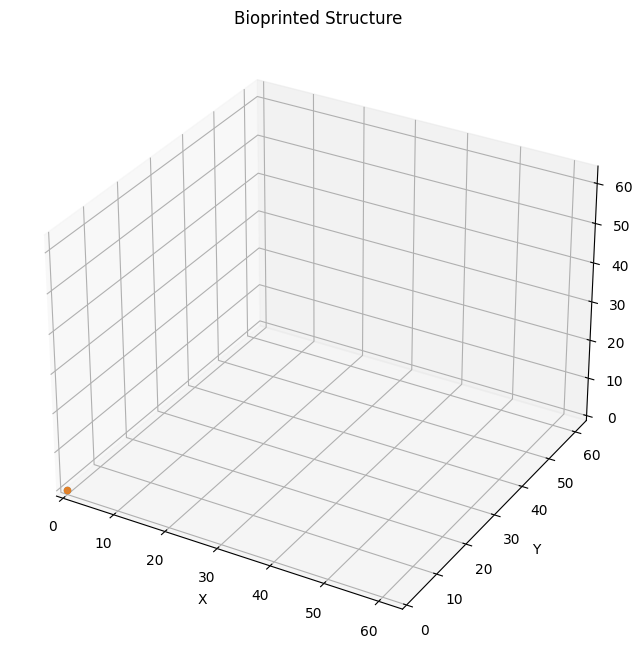

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 60.2     |
| time/              |          |
|    fps             | 102      |
|    iterations      | 1        |
|    time_elapsed    | 20       |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50           |
|    ep_rew_mean          | 60.2         |
| time/                   |              |
|    fps                  | 53           |
|    iterations           | 2            |
|    time_elapsed         | 76           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0063693933 |
|    clip_fraction        | 0.0329       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.97        |
|    explained_variance   | 0.239        |
|    learning_r

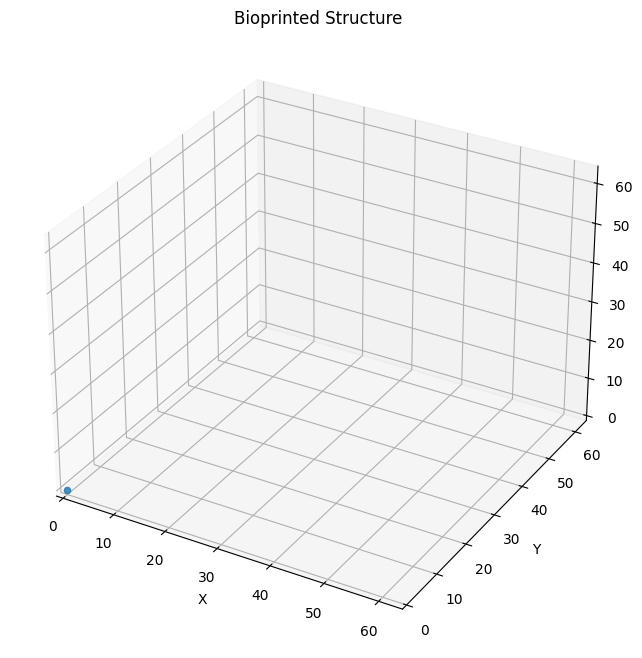

In [ ]:
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class BioprintEnv(gym.Env):
    def __init__(self, resolution=64):
        super(BioprintEnv, self).__init__()

        # Define the number of material types
        self.num_materials = 3

        # Define the observation space with multiple material channels
        self.observation_space = spaces.Box(low=0, high=1.0, shape=(resolution, resolution, resolution, self.num_materials), dtype=np.float32)

        # Define the action space with position, velocity, and material selection
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(7,), dtype=np.float32)

        # Initialize the current step
        self.current_step = 0

        # Define the maximum number of steps per episode
        self.max_steps = 50

        # Initialize the bioprinting environment with multiple material channels
        self.bioprint_env = self.initialize_bioprint_env()

        # Define the target organ geometry with multiple material channels
        self.target_geometry = self.define_target_geometry()

        # Define the target organ functional metrics
        self.target_function = self.define_target_function()

        # Define the print head parameters
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        self.material_deposition_rate = 0.1

    def initialize_bioprint_env(self):
        # Initialize the bioprinting environment with multiple material channels
        initial_state = np.zeros(self.observation_space.shape, dtype=np.float32)
        return initial_state

    def define_target_geometry(self):
        # Define the target organ geometry with multiple material channels
        target_geometry = np.zeros(self.observation_space.shape, dtype=np.float32)
        target_geometry[20:40, 20:40, 20:40, 0] = 1.0  # Material 1
        target_geometry[25:35, 25:35, 25:35, 1] = 1.0  # Material 2
        target_geometry[30:32, 30:32, 30:32, 2] = 1.0  # Material 3
        return target_geometry

    def define_target_function(self):
        # Define the target organ functional metrics
        target_function = {'porosity': [0.8, 0.7, 0.6], 'elasticity': [0.9, 0.8, 0.7]}
        return target_function

    def step(self, action):
        # Apply the action to the bioprinting environment
        self.apply_action(action)

        # Simulate the bioprinting process
        self.simulate_bioprinting()

        # Get the current observation
        observation = self.get_observation()

        # Calculate the reward
        reward = self.calculate_reward(observation)

        # Increment the current step
        self.current_step += 1

        # Check if the episode is done
        done = (self.current_step >= self.max_steps)

        # Create an info dictionary
        info = {}

        return observation, reward, done, info

    def apply_action(self, action):
        # Apply the action to the bioprinting environment
        self.print_head_position += action[:3] * 0.1
        self.print_head_velocity = action[3:6] * 10.0
        self.selected_material = int(np.clip(action[6], 0, self.num_materials - 1))

        # Clip print head position to stay within the boundaries
        self.print_head_position = np.clip(self.print_head_position, 0, self.observation_space.shape[0] - 1)

    def simulate_bioprinting(self):
        # Simulate the bioprinting process with multiple materials
        deposition_location = self.print_head_position.astype(int)
        deposition_amount = self.material_deposition_rate * np.linalg.norm(self.print_head_velocity)

        # Update the bioprinting environment at the deposition location for the selected material
        self.bioprint_env[deposition_location[0], deposition_location[1], deposition_location[2], self.selected_material] += deposition_amount

        # Clip the bioprinting environment values to stay within the valid range
        self.bioprint_env = np.clip(self.bioprint_env, 0, 1)

    def get_observation(self):
        # Get the current observation of the bioprinting environment
        observation = self.bioprint_env
        return observation

    def calculate_reward(self, observation):
        # Calculate the reward based on geometric accuracy and functional performance

        # Geometric accuracy reward
        geometry_similarity = np.sum(observation == self.target_geometry) / np.prod(observation.shape)
        geometry_reward = geometry_similarity

        # Functional performance reward
        porosity_reward = 0
        elasticity_reward = 0
        for i in range(self.num_materials):
            porosity = np.mean(observation[:, :, :, i] < 0.5)
            elasticity = np.mean(observation[:, :, :, i])
            porosity_reward += np.exp(-((porosity - self.target_function['porosity'][i]) ** 2) / 0.1)
            elasticity_reward += np.exp(-((elasticity - self.target_function['elasticity'][i]) ** 2) / 0.1)

        functional_reward = (porosity_reward + elasticity_reward) / (2 * self.num_materials)

        # Combine geometric accuracy and functional performance rewards
        reward = geometry_reward + functional_reward

        return reward

    def reset(self):
        # Reset the bioprinting environment to its initial state
        self.bioprint_env = self.initialize_bioprint_env()
        self.current_step = 0
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        return self.get_observation()

    def render(self, mode='human'):
        # Render the bioprinting environment using a 3D plot
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Plot the bioprinted structure
        for i in range(self.num_materials):
            material_indices = np.where(self.bioprint_env[:, :, :, i] > 0)
            ax.scatter(material_indices[0], material_indices[1], material_indices[2], c=f'C{i}', alpha=0.8)

        # Set the axis labels and title
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('Bioprinted Structure')

        # Set the axis limits
        ax.set_xlim(0, self.observation_space.shape[0] - 1)
        ax.set_ylim(0, self.observation_space.shape[1] - 1)
        ax.set_zlim(0, self.observation_space.shape[2] - 1)

        # Display the plot
        plt.show()

def evaluate_model(model, env, num_episodes):
    # Evaluate the model for a given number of episodes
    total_reward = 0
    for _ in range(num_episodes):
        obs = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward

    mean_reward = total_reward / num_episodes
    return mean_reward

# Create the bioprinting environment with a lower resolution
env = BioprintEnv(resolution=64)

# Create the PPO model
model = PPO("MlpPolicy", env, verbose=1)

# Set up the training loop
total_timesteps = 50000
checkpoint_interval = 5000

# Training loop
for i in range(total_timesteps // checkpoint_interval):
    model.learn(total_timesteps=checkpoint_interval)
    model.save(f"bioprint_model_{(i+1)*checkpoint_interval}_steps")
    mean_reward = evaluate_model(model, env, num_episodes=5)
    print(f"Mean reward at step {(i+1)*checkpoint_interval}: {mean_reward:.2f}")

    if mean_reward < 0.5:
        print("Warning: Mean reward is low. Adjusting the learning process.")
        # Adjust the learning rate or other hyperparameters
        model.learning_rate = 0.0001

    if (i+1) % 5 == 0:
        print(f"Completed {(i+1)*checkpoint_interval} training steps.")

        # Render the current state of the bioprinting environment
        env.render()

In [ ]:
!pip install gym numpy stable-baselines3 matplotlib

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 60.1     |
| time/              |          |
|    fps             | 395      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
Mean reward at step 2000: 60.11
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 60.1     |
| time/              |          |
|    fps             | 398      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
Mean reward at step 4000: 60.11
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 60.1     |
| time/              |   

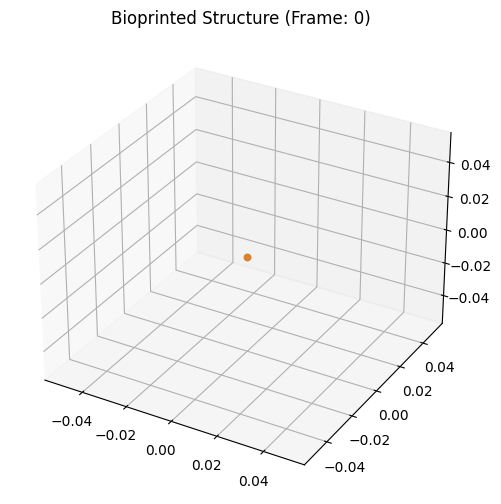

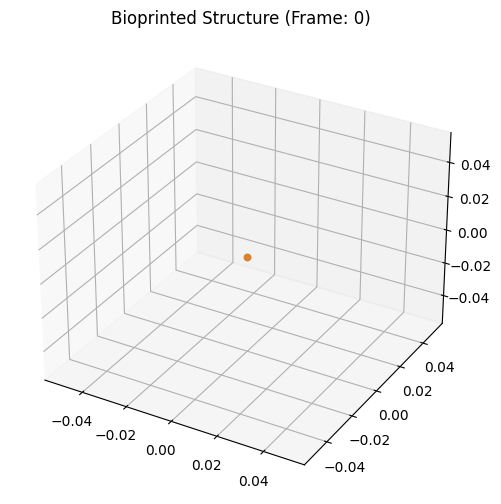

In [ ]:
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

class BioprintEnv(gym.Env):
    def __init__(self, resolution=32):  # Changed resolution from 64 to 32 for efficiency
        super(BioprintEnv, self).__init__()
        self.num_materials = 3
        self.observation_space = spaces.Box(low=0, high=1.0, shape=(resolution, resolution, resolution, self.num_materials), dtype=np.float32)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(7,), dtype=np.float32)
        self.current_step = 0
        self.max_steps = 50
        self.bioprint_env = self.initialize_bioprint_env()
        self.target_geometry = self.define_target_geometry()
        self.target_function = self.define_target_function()
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        self.material_deposition_rate = 0.1

    def initialize_bioprint_env(self):
        return np.zeros(self.observation_space.shape, dtype=np.float32)

    def define_target_geometry(self):
        target_geometry = np.zeros(self.observation_space.shape, dtype=np.float32)
        target_geometry[10:20, 10:20, 10:20, 0] = 1.0  # Adjusted for new resolution
        target_geometry[12:18, 12:18, 12:18, 1] = 1.0
        target_geometry[14:16, 14:16, 14:16, 2] = 1.0
        return target_geometry

    def define_target_function(self):
        return {'porosity': [0.8, 0.7, 0.6], 'elasticity': [0.9, 0.8, 0.7]}

    def step(self, action):
        self.apply_action(action)
        self.simulate_bioprinting()
        observation = self.get_observation()
        reward = self.calculate_reward(observation)
        self.current_step += 1
        done = (self.current_step >= self.max_steps)
        return observation, reward, done, {}

    def apply_action(self, action):
        self.print_head_position += action[:3] * 0.1
        self.print_head_velocity = action[3:6] * 10.0
        self.selected_material = int(np.clip(action[6], 0, self.num_materials - 1))
        self.print_head_position = np.clip(self.print_head_position, 0, self.observation_space.shape[0] - 1)

    def simulate_bioprinting(self):
        deposition_location = self.print_head_position.astype(int)
        deposition_amount = self.material_deposition_rate * np.linalg.norm(self.print_head_velocity)
        self.bioprint_env[deposition_location[0], deposition_location[1], deposition_location[2], self.selected_material] += deposition_amount
        self.bioprint_env = np.clip(self.bioprint_env, 0, 1)

    def get_observation(self):
        return self.bioprint_env

    def calculate_reward(self, observation):
        geometry_similarity = np.sum(observation == self.target_geometry) / np.prod(observation.shape)
        geometry_reward = geometry_similarity
        porosity_reward = 0
        elasticity_reward = 0
        for i in range(self.num_materials):
            porosity = np.mean(observation[:, :, :, i] < 0.5)
            elasticity = np.mean(observation[:, :, :, i])
            porosity_reward += np.exp(-((porosity - self.target_function['porosity'][i]) ** 2) / 0.1)
            elasticity_reward += np.exp(-((elasticity - self.target_function['elasticity'][i]) ** 2) / 0.1)
        functional_reward = (porosity_reward + elasticity_reward) / (2 * self.num_materials)
        return geometry_reward + functional_reward

    def reset(self):
        self.bioprint_env = self.initialize_bioprint_env()
        self.current_step = 0
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        return self.get_observation()

    def render(self, mode='human', save_animation=False):
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')
        scatters = []
        colors = ['C0', 'C1', 'C2']
        def update(frame):
            for scatter in scatters:
                scatter.remove()
            scatters.clear()
            for i in range(self.num_materials):
                material_indices = np.where(self.bioprint_env[:, :, :, i] > frame / self.max_steps)
                scatter = ax.scatter(material_indices[0], material_indices[1], material_indices[2], c=colors[i], alpha=0.8)
                scatters.append(scatter)
            ax.set_title(f'Bioprinted Structure (Frame: {frame})')
        frames = range(0, self.max_steps + 1, 10)
        animation = FuncAnimation(fig, update, frames=frames, interval=100, blit=False)
        if save_animation:
            animation.save('bioprinting_animation.mp4', writer='ffmpeg')
        else:
            plt.show()

env = BioprintEnv(resolution=32)
model = PPO("MlpPolicy", env, verbose=1)
total_timesteps = 20000
checkpoint_interval = 2000

for i in range(total_timesteps // checkpoint_interval):
    model.learn(total_timesteps=checkpoint_interval)
    model.save(f"bioprint_model_{(i+1)*checkpoint_interval}_steps")
    mean_reward = evaluate_model(model, env, num_episodes=3)
    print(f"Mean reward at step {(i+1)*checkpoint_interval}: {mean_reward:.2f}")
    if mean_reward < 0.5:
        print("Warning: Mean reward is low. Adjusting the learning process.")
        model.learning_rate = 0.0001
    if (i+1) % 5 == 0:
        print(f"Completed {(i+1)*checkpoint_interval} training steps.")
        env.render(save_animation=True)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 60.1     |
| time/              |          |
|    fps             | 415      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
Mean reward at step 2000: 60.11
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 60.1     |
| time/              |          |
|    fps             | 380      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
Mean reward at step 4000: 60.11
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 60.1     |
| time/              |   

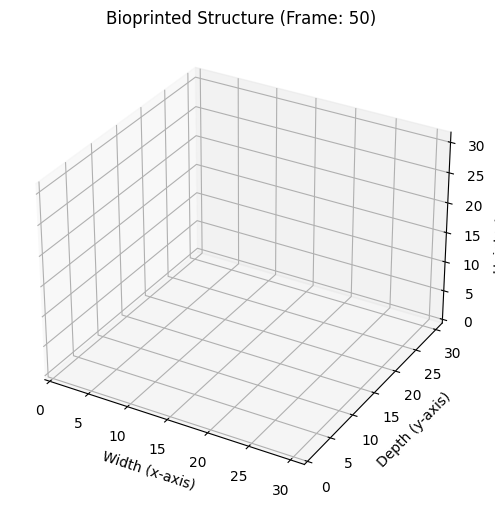

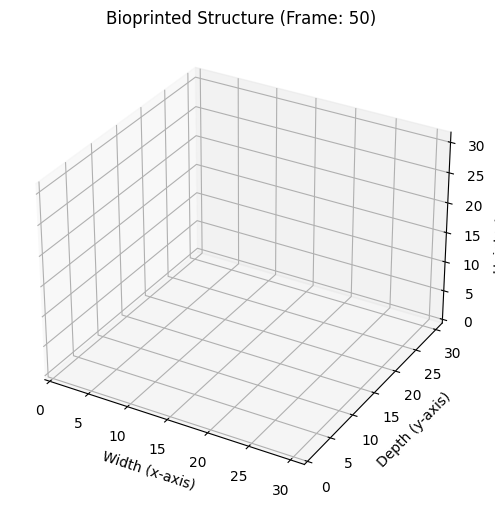

In [ ]:
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

class BioprintEnv(gym.Env):
    """Custom Environment for bioprinting that follows gym interface"""
    def __init__(self, resolution=32):
        super(BioprintEnv, self).__init__()
        self.num_materials = 3  # Number of different materials that can be printed
        self.observation_space = spaces.Box(low=0, high=1.0,
                                            shape=(resolution, resolution, resolution, self.num_materials),
                                            dtype=np.float32)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(7,), dtype=np.float32)
        self.current_step = 0
        self.max_steps = 50
        self.bioprint_env = self.initialize_bioprint_env()
        self.target_geometry = self.define_target_geometry()
        self.target_function = self.define_target_function()
        self.print_head_position = np.zeros(3)  # XYZ coordinates of the print head
        self.print_head_velocity = np.zeros(3)  # Velocity of the print head in XYZ
        self.material_deposition_rate = 0.1  # Rate at which material is deposited

    def initialize_bioprint_env(self):
        """Initializes the bioprinting environment with zeros"""
        return np.zeros(self.observation_space.shape, dtype=np.float32)

    def define_target_geometry(self):
        """Defines the target geometry to be achieved by the bioprinter"""
        target_geometry = np.zeros(self.observation_space.shape, dtype=np.float32)
        target_geometry[10:20, 10:20, 10:20, 0] = 1.0
        target_geometry[12:18, 12:18, 12:18, 1] = 1.0
        target_geometry[14:16, 14:16, 14:16, 2] = 1.0
        return target_geometry

    def define_target_function(self):
        """Defines the functional requirements like porosity and elasticity for the target organ"""
        return {'porosity': [0.8, 0.7, 0.6], 'elasticity': [0.9, 0.8, 0.7]}

    def step(self, action):
        """Apply the action to the environment"""
        self.apply_action(action)
        self.simulate_bioprinting()
        observation = self.get_observation()
        reward = self.calculate_reward(observation)
        self.current_step += 1
        done = (self.current_step >= self.max_steps)
        return observation, reward, done, {}

    def apply_action(self, action):
        """Updates the printing head's position and velocity based on the action"""
        self.print_head_position += action[:3] * 0.1
        self.print_head_velocity = action[3:6] * 10.0
        self.selected_material = int(np.clip(action[6], 0, self.num_materials - 1))
        self.print_head_position = np.clip(self.print_head_position, 0, self.observation_space.shape[0] - 1)

    def simulate_bioprinting(self):
        """Simulates the deposition of materials at the current print head position"""
        deposition_location = self.print_head_position.astype(int)
        deposition_amount = self.material_deposition_rate * np.linalg.norm(self.print_head_velocity)
        self.bioprint_env[deposition_location[0], deposition_location[1], deposition_location[2], self.selected_material] += deposition_amount
        self.bioprint_env = np.clip(self.bioprint_env, 0, 1)

    def get_observation(self):
        """Returns the current state of the bioprint environment"""
        return self.bioprint_env

    def calculate_reward(self, observation):
        """Calculates the reward based on how closely the current state matches the target geometry and function"""
        geometry_similarity = np.sum(observation == self.target_geometry) / np.prod(observation.shape)
        geometry_reward = geometry_similarity
        porosity_reward = 0
        elasticity_reward = 0
        for i in range(self.num_materials):
            porosity = np.mean(observation[:, :, :, i] < 0.5)
            elasticity = np.mean(observation[:, :, :, i])
            porosity_reward += np.exp(-((porosity - self.target_function['porosity'][i]) ** 2) / 0.1)
            elasticity_reward += np.exp(-((elasticity - self.target_function['elasticity'][i]) ** 2) / 0.1)
        functional_reward = (porosity_reward + elasticity_reward) / (2 * self.num_materials)
        return geometry_reward + functional_reward

    def reset(self):
        """Resets the environment to an initial state and returns the initial observation"""
        self.bioprint_env = self.initialize_bioprint_env()
        self.current_step = 0
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        return self.get_observation()

    def render(self, mode='human', save_animation=False):
        """Renders the environment with the option to save as an animation"""
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')
        scatters = [ax.scatter([], [], [], c=f'C{i}', alpha=0.8) for i in range(self.num_materials)]

        def init():
            for scatter in scatters:
                scatter._offsets3d = ([], [], [])
            return scatters

        def update(frame):
            for i in range(self.num_materials):
                material_indices = np.where(self.bioprint_env[:, :, :, i] > frame / self.max_steps)
                scatters[i]._offsets3d = (material_indices[0], material_indices[1], material_indices[2])
            ax.set_title(f'Bioprinted Structure (Frame: {frame})')
            return scatters

        ax.set_xlabel('Width (x-axis)')
        ax.set_ylabel('Depth (y-axis)')
        ax.set_zlabel('Height (z-axis)')
        ax.set_title('Bioprinted Structure')
        ax.set_xlim(0, self.observation_space.shape[0] - 1)
        ax.set_ylim(0, self.observation_space.shape[1] - 1)
        ax.set_zlim(0, self.observation_space.shape[2] - 1)

        frames = range(0, self.max_steps + 1)
        animation = FuncAnimation(fig, update, frames=frames, init_func=init, interval=100, blit=True)

        if save_animation:
            animation.save('bioprinting_animation.mp4', writer='ffmpeg', dpi=300)
        else:
            plt.show()

# Example usage and training code
env = BioprintEnv(resolution=32)
model = PPO("MlpPolicy", env, verbose=1)

# Set up the training loop
total_timesteps = 20000
checkpoint_interval = 2000

for i in range(total_timesteps // checkpoint_interval):
    model.learn(total_timesteps=checkpoint_interval)
    model.save(f"bioprint_model_{(i+1)*checkpoint_interval}_steps")
    mean_reward = evaluate_model(model, env, num_episodes=3)
    print(f"Mean reward at step {(i+1)*checkpoint_interval}: {mean_reward:.2f}")

    if mean_reward < 0.5:
        print("Warning: Mean reward is low. Adjusting the learning process.")
        model.learning_rate = 0.0001

    if (i+1) % 5 == 0:
        print(f"Completed {(i+1)*checkpoint_interval} training steps.")
        env.render(save_animation=True)



In [ ]:
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import os
from IPython.display import HTML
from base64 import b64encode

class BioprintEnv(gym.Env):
    """Custom Environment for bioprinting that follows gym interface"""
    def __init__(self, resolution=32):
        super(BioprintEnv, self).__init__()
        self.num_materials = 3  # Number of different materials that can be printed
        self.observation_space = spaces.Box(low=0, high=1.0,
                                            shape=(resolution, resolution, resolution, self.num_materials),
                                            dtype=np.float32)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(7,), dtype=np.float32)
        self.current_step = 0
        self.max_steps = 50
        self.bioprint_env = np.zeros(self.observation_space.shape, dtype=np.float32)
        self.target_geometry = np.zeros(self.observation_space.shape, dtype=np.float32)
        self.target_function = {'porosity': [0.8, 0.7, 0.6], 'elasticity': [0.9, 0.8, 0.7]}
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        self.material_deposition_rate = 0.1

    def step(self, action):
        self.apply_action(action)
        self.simulate_bioprinting()
        observation = self.get_observation()
        reward = self.calculate_reward(observation)
        self.current_step += 1
        done = (self.current_step >= self.max_steps)
        return observation, reward, done, {}

    def apply_action(self, action):
        self.print_head_position += action[:3] * 0.1
        self.print_head_velocity = action[3:6] * 10.0
        self.selected_material = int(np.clip(action[6], 0, self.num_materials - 1))
        self.print_head_position = np.clip(self.print_head_position, 0, self.observation_space.shape[0] - 1)

    def simulate_bioprinting(self):
        deposition_location = self.print_head_position.astype(int)
        deposition_amount = self.material_deposition_rate * np.linalg.norm(self.print_head_velocity)
        self.bioprint_env[deposition_location[0], deposition_location[1], deposition_location[2], self.selected_material] += deposition_amount
        self.bioprint_env = np.clip(self.bioprint_env, 0, 1)

    def get_observation(self):
        return self.bioprint_env

    def calculate_reward(self, observation):
        geometry_similarity = np.sum(observation == self.target_geometry) / np.prod(observation.shape)
        geometry_reward = geometry_similarity
        porosity_reward = 0
        elasticity_reward = 0
        for i in range(self.num_materials):
            porosity = np.mean(observation[:, :, :, i] < 0.5)
            elasticity = np.mean(observation[:, :, :, i])
            porosity_reward += np.exp(-((porosity - self.target_function['porosity'][i]) ** 2) / 0.1)
            elasticity_reward += np.exp(-((elasticity - self.target_function['elasticity'][i]) ** 2) / 0.1)
        functional_reward = (porosity_reward + elasticity_reward) / (2 * self.num_materials)
        return geometry_reward + functional_reward

    def reset(self):
        self.current_step = 0
        self.bioprint_env = np.zeros(self.observation_space.shape, dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        return self.get_observation()

def evaluate_model(model, env, num_episodes):
    total_reward = 0
    for _ in range(num_episodes):
        obs = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            total_reward += reward
    return total_reward / num_episodes

# Example usage and training code
env = BioprintEnv(resolution=32)
model = PPO("MlpPolicy", env, verbose=1)

# Set up the training loop
total_timesteps = 20000
checkpoint_interval = 2000

for i in range(total_timesteps // checkpoint_interval):
    model.learn(total_timesteps=checkpoint_interval)
    model.save(f"bioprint_model_{(i+1)*checkpoint_interval}_steps")
    mean_reward = evaluate_model(model, env, num_episodes=3)
    print(f"Mean reward at step {(i+1)*checkpoint_interval}: {mean_reward:.2f}")

    if mean_reward < 0.5:
        print("Warning: Mean reward is low. Adjusting the learning process.")
        model.learning_rate = 0.0001

    if (i+1) % 5 == 0:
        print(f"Completed {(i+1)*checkpoint_interval} training steps.")
        # Rendering can be added here if needed



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 60.7     |
| time/              |          |
|    fps             | 419      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
Mean reward at step 2000: 60.73
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 60.7     |
| time/              |          |
|    fps             | 423      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
Mean reward at step 4000: 60.74
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 60.7     |
| time/              |   

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 106.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 11.0 MB/s eta 0:00:00


In [ ]:
%%writefile bioprint_app.py
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import gym
from gym import spaces

class BioprintEnv(gym.Env):
    """Custom Environment for bioprinting that follows gym interface"""
    def __init__(self, resolution=32):
        super(BioprintEnv, self).__init__()
        self.num_materials = 3  # Number of different materials that can be printed
        self.observation_space = spaces.Box(low=0, high=1.0,
                                            shape=(resolution, resolution, resolution, self.num_materials),
                                            dtype=np.float32)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(7,), dtype=np.float32)
        self.current_step = 0
        self.max_steps = 50
        self.bioprint_env = np.zeros(self.observation_space.shape, dtype=np.float32)
        self.target_geometry = np.zeros(self.observation_space.shape, dtype=np.float32)
        self.target_function = {'porosity': [0.8, 0.7, 0.6], 'elasticity': [0.9, 0.8, 0.7]}
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        self.material_deposition_rate = 0.1

    def step(self, action):
        self.apply_action(action)
        self.simulate_bioprinting()
        observation = self.get_observation()
        reward = self.calculate_reward(observation)
        self.current_step += 1
        done = (self.current_step >= self.max_steps)
        return observation, reward, done, {}

    def apply_action(self, action):
        self.print_head_position += action[:3] * 0.1
        self.print_head_velocity = action[3:6] * 10.0
        self.selected_material = int(np.clip(action[6], 0, self.num_materials - 1))
        self.print_head_position = np.clip(self.print_head_position, 0, self.observation_space.shape[0] - 1)

    def simulate_bioprinting(self):
        deposition_location = self.print_head_position.astype(int)
        deposition_amount = self.material_deposition_rate * np.linalg.norm(self.print_head_velocity)
        self.bioprint_env[deposition_location[0], deposition_location[1], deposition_location[2], self.selected_material] += deposition_amount
        self.bioprint_env = np.clip(self.bioprint_env, 0, 1)

    def get_observation(self):
        return self.bioprint_env

    def calculate_reward(self, observation):
        geometry_similarity = np.sum(observation == self.target_geometry) / np.prod(observation.shape)
        geometry_reward = geometry_similarity
        porosity_reward = 0
        elasticity_reward = 0
        for i in range(self.num_materials):
            porosity = np.mean(observation[:, :, :, i] < 0.5)
            elasticity = np.mean(observation[:, :, :, i])
            porosity_reward += np.exp(-((porosity - self.target_function['porosity'][i]) ** 2) / 0.1)
            elasticity_reward += np.exp(-((elasticity - self.target_function['elasticity'][i]) ** 2) / 0.1)
        functional_reward = (porosity_reward + elasticity_reward) / (2 * self.num_materials)
        return geometry_reward + functional_reward

    def reset(self):
        self.current_step = 0
        self.bioprint_env = np.zeros(self.observation_space.shape, dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        return self.get_observation()

# Initialize the environment
env = BioprintEnv()

# Set up the Streamlit app
st.set_page_config(page_title="3D Bioprinting Simulation", layout="wide")

# Create sidebar for controls
st.sidebar.title("Simulation Controls")

# Button to reset the simulation environment
if st.sidebar.button("Reset Environment"):
    observation = env.reset()
    st.sidebar.success("Environment has been reset.")

# Sliders to customize the action input
action_input = []
for i in range(env.action_space.shape[0]):
    action_val = st.sidebar.slider(f"Action Dimension {i}", -1.0, 1.0, 0.0, 0.1)
    action_input.append(action_val)

# Button to perform a custom action
if st.sidebar.button("Perform Action"):
    observation, reward, done, info = env.step(action_input)
    st.sidebar.write(f"Reward: {reward:.2f}")
    st.sidebar.write(f"Done: {done}")

# Checkbox to toggle animation
animate = st.sidebar.checkbox("Animate Bioprinting", value=True)

# Selectbox for choosing the visualization aspect
viz_aspect = st.sidebar.selectbox(
    "Visualization Aspect",
    ("Bioprinted Structure", "Target Geometry", "Porosity", "Elasticity"),
)

# Create main content area
st.title("3D Bioprinting Simulation")

# Render the selected visualization aspect
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

if viz_aspect == "Bioprinted Structure":
    for i in range(env.num_materials):
        material_indices = np.where(env.bioprint_env[:, :, :, i] > 0)
        ax.scatter(
            material_indices[0],
            material_indices[1],
            material_indices[2],
            c=f"C{i}",
            alpha=0.8,
            label=f"Material {i+1}",
        )
    ax.set_title("Bioprinted Structure")
elif viz_aspect == "Target Geometry":
    for i in range(env.num_materials):
        material_indices = np.where(env.target_geometry[:, :, :, i] > 0)
        ax.scatter(
            material_indices[0],
            material_indices[1],
            material_indices[2],
            c=f"C{i}",
            alpha=0.8,
            label=f"Material {i+1}",
        )
    ax.set_title("Target Geometry")
elif viz_aspect == "Porosity":
    porosity = np.zeros(env.observation_space.shape[:3])
    for i in range(env.num_materials):
        porosity += env.bioprint_env[:, :, :, i] < 0.5
    porosity /= env.num_materials
    ax.voxels(porosity, edgecolor="k", facecolors="viridis", shade=False)
    ax.set_title("Porosity")
    fig.colorbar(ax.voxels(porosity), label="Porosity")
elif viz_aspect == "Elasticity":
    elasticity = np.mean(env.bioprint_env, axis=-1)
    ax.voxels(elasticity, edgecolor="k", facecolors="inferno", shade=False)
    ax.set_title("Elasticity")
    fig.colorbar(ax.voxels(elasticity), label="Elasticity")

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

# Display the plot
st.pyplot(fig)

# Render the bioprinting animation
if animate:
    fig_anim = plt.figure(figsize=(8, 8))
    ax_anim = fig_anim.add_subplot(111, projection="3d")

    def update(frame):
        ax_anim.clear()
        for i in range(env.num_materials):
            material_indices = np.where(env.bioprint_env[:, :, :, i] > frame / env.max_steps)
            ax_anim.scatter(
                material_indices[0],
                material_indices[1],
                material_indices[2],
                c=f"C{i}",
                alpha=0.8,
            )
        ax_anim.set_title(f"Bioprinted Structure (Frame: {frame})")
        ax_anim.set_xlabel("X")
        ax_anim.set_ylabel("Y")
        ax_anim.set_zlabel("Z")
        ax_anim.set_xlim(0, env.observation_space.shape[0])
        ax_anim.set_ylim(0, env.observation_space.shape[1])
        ax_anim.set_zlim(0, env.observation_space.shape[2])

    anim = FuncAnimation(fig_anim, update, frames=env.max_steps, interval=100)
    st.pyplot(fig_anim)

# Display simulation information
st.sidebar.subheader("Simulation Information")
st.sidebar.write(f"Current Step: {env.current_step}")
st.sidebar.write(f"Max Steps: {env.max_steps}")
st.sidebar.write(f"Observation Shape: {env.observation_space.shape}")
st.sidebar.write(f"Action Shape: {env.action_space.shape}")

Writing bioprint_app.py


In [ ]:
%%writefile bioprint_app.py
!pip install streamlit numpy matplotlib gym stable-baselines3

import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import gym
from gym import spaces
from stable_baselines3 import PPO

class BioprintEnv(gym.Env):
    # ... (BioprintEnv class implementation remains the same) ...

def simulate_bioprinting(env, model, num_steps):
    obs = env.reset()
    bioprint_history = [obs.copy()]
    for _ in range(num_steps):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, _, _ = env.step(action)
        bioprint_history.append(obs.copy())
    return bioprint_history

# Initialize the environment
env = BioprintEnv()

# Create and train the PPO model
model = PPO("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=10000)

# Set up the Streamlit app
st.set_page_config(page_title="3D Bioprinting Simulation", layout="wide")

# Create sidebar for controls
st.sidebar.title("Simulation Controls")

# Button to run the simulation
if st.sidebar.button("Run Simulation"):
    num_steps = st.sidebar.number_input("Number of Simulation Steps", min_value=1, value=50, step=1)
    bioprint_history = simulate_bioprinting(env, model, num_steps)
    st.sidebar.success(f"Simulation completed for {num_steps} steps.")

# Selectbox for choosing the visualization aspect
viz_aspect = st.sidebar.selectbox(
    "Visualization Aspect",
    ("Bioprinted Structure", "Target Geometry", "Porosity", "Elasticity"),
)

# Create main content area
st.title("3D Bioprinting Simulation")

# Render the selected visualization aspect
if 'bioprint_history' in locals():
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    if viz_aspect == "Bioprinted Structure":
        obs = bioprint_history[-1]
        for i in range(env.num_materials):
            material_indices = np.where(obs[:, :, :, i] > 0)
            ax.scatter(
                material_indices[0],
                material_indices[1],
                material_indices[2],
                c=f"C{i}",
                alpha=0.8,
                label=f"Material {i+1}",
            )
        ax.set_title("Bioprinted Structure")
    elif viz_aspect == "Target Geometry":
        for i in range(env.num_materials):
            material_indices = np.where(env.target_geometry[:, :, :, i] > 0)
            ax.scatter(
                material_indices[0],
                material_indices[1],
                material_indices[2],
                c=f"C{i}",
                alpha=0.8,
                label=f"Material {i+1}",
            )
        ax.set_title("Target Geometry")
    elif viz_aspect == "Porosity":
        obs = bioprint_history[-1]
        porosity = np.zeros(env.observation_space.shape[:3])
        for i in range(env.num_materials):
            porosity += obs[:, :, :, i] < 0.5
        porosity /= env.num_materials
        ax.voxels(porosity, edgecolor="k", facecolors="viridis", shade=False)
        ax.set_title("Porosity")
        fig.colorbar(ax.voxels(porosity), label="Porosity")
    elif viz_aspect == "Elasticity":
        obs = bioprint_history[-1]
        elasticity = np.mean(obs, axis=-1)
        ax.voxels(elasticity, edgecolor="k", facecolors="inferno", shade=False)
        ax.set_title("Elasticity")
        fig.colorbar(ax.voxels(elasticity), label="Elasticity")

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()

    # Display the plot
    st.pyplot(fig)

# Render the bioprinting animation
if 'bioprint_history' in locals() and st.sidebar.checkbox("Animate Bioprinting", value=True):
    fig_anim = plt.figure(figsize=(8, 8))
    ax_anim = fig_anim.add_subplot(111, projection="3d")

    def update(frame):
        ax_anim.clear()
        obs = bioprint_history[frame]
        for i in range(env.num_materials):
            material_indices = np.where(obs[:, :, :, i] > 0)
            ax_anim.scatter(
                material_indices[0],
                material_indices[1],
                material_indices[2],
                c=f"C{i}",
                alpha=0.8,
            )
        ax_anim.set_title(f"Bioprinted Structure (Frame: {frame})")
        ax_anim.set_xlabel("X")
        ax_anim.set_ylabel("Y")
        ax_anim.set_zlabel("Z")
        ax_anim.set_xlim(0, env.observation_space.shape[0])
        ax_anim.set_ylim(0, env.observation_space.shape[1])
        ax_anim.set_zlim(0, env.observation_space.shape[2])

    anim = FuncAnimation(fig_anim, update, frames=len(bioprint_history), interval=100)
    st.pyplot(fig_anim)

Overwriting bioprint_app.py


In [ ]:
%%writefile bioprint_app.py
!pip install streamlit numpy matplotlib gym stable-baselines3

import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import gym
from gym import spaces
from stable_baselines3 import PPO

class BioprintEnv(gym.Env):
    """Custom Environment for bioprinting that follows gym interface"""
    def __init__(self, resolution=32):
        super(BioprintEnv, self).__init__()
        self.num_materials = 3  # Number of different materials that can be printed
        self.observation_space = spaces.Box(low=0, high=1.0,
                                            shape=(resolution, resolution, resolution, self.num_materials),
                                            dtype=np.float32)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(7,), dtype=np.float32)
        self.current_step = 0
        self.max_steps = 50
        self.bioprint_env = np.zeros(self.observation_space.shape, dtype=np.float32)
        self.target_geometry = np.zeros(self.observation_space.shape, dtype=np.float32)
        self.target_function = {'porosity': [0.8, 0.7, 0.6], 'elasticity': [0.9, 0.8, 0.7]}
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        self.material_deposition_rate = 0.1

    def step(self, action):
        self.apply_action(action)
        self.simulate_bioprinting()
        observation = self.get_observation()
        reward = self.calculate_reward(observation)
        self.current_step += 1
        done = (self.current_step >= self.max_steps)
        return observation, reward, done, {}

    def apply_action(self, action):
        self.print_head_position += action[:3] * 0.1
        self.print_head_velocity = action[3:6] * 10.0
        self.selected_material = int(np.clip(action[6], 0, self.num_materials - 1))
        self.print_head_position = np.clip(self.print_head_position, 0, self.observation_space.shape[0] - 1)

    def simulate_bioprinting(self):
        deposition_location = self.print_head_position.astype(int)
        deposition_amount = self.material_deposition_rate * np.linalg.norm(self.print_head_velocity)
        self.bioprint_env[deposition_location[0], deposition_location[1], deposition_location[2], self.selected_material] += deposition_amount
        self.bioprint_env = np.clip(self.bioprint_env, 0, 1)

    def get_observation(self):
        return self.bioprint_env

    def calculate_reward(self, observation):
        geometry_similarity = np.sum(observation == self.target_geometry) / np.prod(observation.shape)
        geometry_reward = geometry_similarity
        porosity_reward = 0
        elasticity_reward = 0
        for i in range(self.num_materials):
            porosity = np.mean(observation[:, :, :, i] < 0.5)
            elasticity = np.mean(observation[:, :, :, i])
            porosity_reward += np.exp(-((porosity - self.target_function['porosity'][i]) ** 2) / 0.1)
            elasticity_reward += np.exp(-((elasticity - self.target_function['elasticity'][i]) ** 2) / 0.1)
        functional_reward = (porosity_reward + elasticity_reward) / (2 * self.num_materials)
        return geometry_reward + functional_reward

    def reset(self):
        self.current_step = 0
        self.bioprint_env = np.zeros(self.observation_space.shape, dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        return self.get_observation()

def simulate_bioprinting(env, model, num_steps):
    obs = env.reset()
    bioprint_history = [obs.copy()]
    for _ in range(num_steps):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, _, _ = env.step(action)
        bioprint_history.append(obs.copy())
    return bioprint_history

# Initialize the environment
env = BioprintEnv()

# Create and train the PPO model
model = PPO("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=10000)

# Set up the Streamlit app
st.set_page_config(page_title="3D Bioprinting Simulation", layout="wide")

# Create sidebar for controls
st.sidebar.title("Simulation Controls")

# Button to run the simulation
if st.sidebar.button("Run Simulation"):
    num_steps = st.sidebar.number_input("Number of Simulation Steps", min_value=1, value=50, step=1)
    bioprint_history = simulate_bioprinting(env, model, num_steps)
    st.sidebar.success(f"Simulation completed for {num_steps} steps.")

# Selectbox for choosing the visualization aspect
viz_aspect = st.sidebar.selectbox(
    "Visualization Aspect",
    ("Bioprinted Structure", "Target Geometry", "Porosity", "Elasticity"),
)

# Create main content area
st.title("3D Bioprinting Simulation")

# Render the selected visualization aspect
if 'bioprint_history' in locals():
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    if viz_aspect == "Bioprinted Structure":
        obs = bioprint_history[-1]
        for i in range(env.num_materials):
            material_indices = np.where(obs[:, :, :, i] > 0)
            ax.scatter(
                material_indices[0],
                material_indices[1],
                material_indices[2],
                c=f"C{i}",
                alpha=0.8,
                label=f"Material {i+1}",
            )
        ax.set_title("Bioprinted Structure")
    elif viz_aspect == "Target Geometry":
        for i in range(env.num_materials):
            material_indices = np.where(env.target_geometry[:, :, :, i] > 0)
            ax.scatter(
                material_indices[0],
                material_indices[1],
                material_indices[2],
                c=f"C{i}",
                alpha=0.8,
                label=f"Material {i+1}",
            )
        ax.set_title("Target Geometry")
    elif viz_aspect == "Porosity":
        obs = bioprint_history[-1]
        porosity = np.zeros(env.observation_space.shape[:3])
        for i in range(env.num_materials):
            porosity += obs[:, :, :, i] < 0.5
        porosity /= env.num_materials
        ax.voxels(porosity, edgecolor="k", facecolors="viridis", shade=False)
        ax.set_title("Porosity")
        fig.colorbar(ax.voxels(porosity), label="Porosity")
    elif viz_aspect == "Elasticity":
        obs = bioprint_history[-1]
        elasticity = np.mean(obs, axis=-1)
        ax.voxels(elasticity, edgecolor="k", facecolors="inferno", shade=False)
        ax.set_title("Elasticity")
        fig.colorbar(ax.voxels(elasticity), label="Elasticity")

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()

    # Display the plot
    st.pyplot(fig)

# Render the bioprinting animation
if 'bioprint_history' in locals() and st.sidebar.checkbox("Animate Bioprinting", value=True):
    fig_anim = plt.figure(figsize=(8, 8))
    ax_anim = fig_anim.add_subplot(111, projection="3d")

    def update(frame):
        ax_anim.clear()
        obs = bioprint_history[frame]
        for i in range(env.num_materials):
            material_indices = np.where(obs[:, :, :, i] > 0)
            ax_anim.scatter(
                material_indices[0],
                material_indices[1],
                material_indices[2],
                c=f"C{i}",
                alpha=0.8,
            )
        ax_anim.set_title(f"Bioprinted Structure (Frame: {frame})")
        ax_anim.set_xlabel("X")
        ax_anim.set_ylabel("Y")
        ax_anim.set_zlabel("Z")
        ax_anim.set_xlim(0, env.observation_space.shape[0])
        ax_anim.set_ylim(0, env.observation_space.shape[1])
        ax_anim.set_zlim(0, env.observation_space.shape[2])

    anim = FuncAnimation(fig_anim, update, frames=len(bioprint_history), interval=100)
    st.pyplot(fig_anim)

Overwriting bioprint_app.py


In [ ]:
%%writefile bioprint_app.py

import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import gym
from gym import spaces
from stable_baselines3 import PPO

class BioprintEnv(gym.Env):
    def __init__(self, resolution=32):
        super(BioprintEnv, self).__init__()
        self.resolution = resolution
        self.observation_space = spaces.Box(low=0, high=1.0, shape=(resolution, resolution, resolution), dtype=np.float32)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(6,), dtype=np.float32)
        self.current_step = 0
        self.max_steps = 50
        self.bioprint_env = np.zeros(self.observation_space.shape, dtype=np.float32)
        self.target_geometry = self.generate_target_geometry()
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        self.material_deposition_rate = 0.1

    def generate_target_geometry(self):
        target_geometry = np.zeros(self.observation_space.shape, dtype=np.float32)
        target_geometry[10:20, 10:20, 10:20] = 1.0
        return target_geometry

    def step(self, action):
        self.apply_action(action)
        self.simulate_bioprinting()
        observation = self.get_observation()
        reward = self.calculate_reward(observation)
        self.current_step += 1
        done = (self.current_step >= self.max_steps)
        return observation, reward, done, {}

    def apply_action(self, action):
        self.print_head_position += action[:3] * 0.1
        self.print_head_velocity = action[3:] * 10.0
        self.print_head_position = np.clip(self.print_head_position, 0, self.resolution - 1)

    def simulate_bioprinting(self):
        deposition_location = self.print_head_position.astype(int)
        deposition_amount = self.material_deposition_rate * np.linalg.norm(self.print_head_velocity)
        self.bioprint_env[deposition_location[0], deposition_location[1], deposition_location[2]] += deposition_amount
        self.bioprint_env = np.clip(self.bioprint_env, 0, 1)

    def get_observation(self):
        return self.bioprint_env

    def calculate_reward(self, observation):
        return -np.sum((observation - self.target_geometry) ** 2)

    def reset(self):
        self.current_step = 0
        self.bioprint_env = np.zeros(self.observation_space.shape, dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        return self.get_observation()

def simulate_bioprinting(env, model, num_steps):
    obs = env.reset()
    bioprint_history = [obs.copy()]
    for _ in range(num_steps):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, _, _ = env.step(action)
        bioprint_history.append(obs.copy())
    return bioprint_history

# Initialize the environment
env = BioprintEnv()

# Create and train the PPO model
model = PPO("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=10000)

# Set up the Streamlit app
st.set_page_config(page_title="3D Bioprinting Simulation", layout="wide")
st.title("3D Bioprinting Simulation")

# Sidebar for simulation controls
st.sidebar.title("Simulation Controls")
num_steps = st.sidebar.number_input("Number of Simulation Steps", min_value=1, value=50, step=1)
if st.sidebar.button("Run Simulation"):
    bioprint_history = simulate_bioprinting(env, model, num_steps)
    st.sidebar.success(f"Simulation completed for {num_steps} steps.")

# Display bioprinting results
if 'bioprint_history' in locals():
    # 3D plot of the final bioprinted structure
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    final_structure = bioprint_history[-1]
    ax.voxels(final_structure, edgecolor='k', facecolors='green', shade=False)
    ax.set_title("Final Bioprinted Structure")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    st.pyplot(fig)

    # Display the target geometry
    fig_target = plt.figure(figsize=(6, 6))
    ax_target = fig_target.add_subplot(111, projection='3d')
    ax_target.voxels(env.target_geometry, edgecolor='k', facecolors='blue', shade=False)
    ax_target.set_title("Target Geometry")
    ax_target.set_xlabel("X")
    ax_target.set_ylabel("Y")
    ax_target.set_zlabel("Z")
    st.pyplot(fig_target)

    # Animation of the bioprinting process
    if st.checkbox("Show Bioprinting Animation"):
        fig_anim = plt.figure(figsize=(6, 6))
        ax_anim = fig_anim.add_subplot(111, projection='3d')

        def update(frame):
            ax_anim.clear()
            ax_anim.voxels(bioprint_history[frame], edgecolor='k', facecolors='green', shade=False)
            ax_anim.set_title(f"Bioprinting Progress (Step: {frame})")
            ax_anim.set_xlabel("X")
            ax_anim.set_ylabel("Y")
            ax_anim.set_zlabel("Z")

        anim = FuncAnimation(fig_anim, update, frames=len(bioprint_history), interval=200)
        st.pyplot(fig_anim)

Overwriting bioprint_app.py


In [ ]:
%%writefile cell_bioprint_app.py

import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class CellBioprintEnv:
    def __init__(self, resolution=64):
        self.resolution = resolution
        self.bioprint_env = np.zeros((resolution, resolution, resolution), dtype=np.float32)
        self.growth_factor = 0.1
        self.nutrient_level = 0.5
        self.oxygen_level = 0.5
        self.temperature = 37.0

    def simulate_cell_growth(self):
        cell_center = np.array([self.resolution // 2, self.resolution // 2, self.resolution // 2])
        cell_radius = 5

        if self.nutrient_level >= 0.4 and self.oxygen_level >= 0.4 and 35.0 <= self.temperature <= 39.0:
            cell_radius += self.growth_factor

        x, y, z = np.ogrid[:self.resolution, :self.resolution, :self.resolution]
        distance_from_center = np.sqrt((x - cell_center[0]) ** 2 + (y - cell_center[1]) ** 2 + (z - cell_center[2]) ** 2)
        self.bioprint_env = (distance_from_center <= cell_radius).astype(np.float32)

    def reset(self):
        self.bioprint_env = np.zeros((self.resolution, self.resolution, self.resolution), dtype=np.float32)

# Initialize the environment
env = CellBioprintEnv(resolution=64)

# Set up the Streamlit app
st.set_page_config(page_title="Cell Bioprinting Simulation", layout="wide")
st.title("Cell Bioprinting Simulation")

# Sidebar for simulation controls
st.sidebar.title("Simulation Controls")
env.growth_factor = st.sidebar.slider("Growth Factor", min_value=0.0, max_value=1.0, value=0.1, step=0.01)
env.nutrient_level = st.sidebar.slider("Nutrient Level", min_value=0.0, max_value=1.0, value=0.5, step=0.1)
env.oxygen_level = st.sidebar.slider("Oxygen Level", min_value=0.0, max_value=1.0, value=0.5, step=0.1)
env.temperature = st.sidebar.slider("Temperature (°C)", min_value=20.0, max_value=50.0, value=37.0, step=0.1)

if st.sidebar.button("Reset Simulation"):
    env.reset()
    st.sidebar.success("Simulation reset.")

# Display cell bioprinting results
env.simulate_cell_growth()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
cell_indices = np.where(env.bioprint_env > 0)
ax.scatter(cell_indices[0], cell_indices[1], cell_indices[2], c='red', alpha=0.8)
ax.set_title("Bioprinted Cell")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
st.pyplot(fig)

# Display cell conditions
st.subheader("Cell Conditions")
col1, col2 = st.columns(2)
with col1:
    st.write("Nutrient Level:")
    nutrient_sufficient = env.nutrient_level >= 0.4
    st.write(f"{env.nutrient_level:.2f} ({'Sufficient' if nutrient_sufficient else 'Insufficient'})")

    st.write("Oxygen Level:")
    oxygen_sufficient = env.oxygen_level >= 0.4
    st.write(f"{env.oxygen_level:.2f} ({'Sufficient' if oxygen_sufficient else 'Insufficient'})")

with col2:
    st.write("Temperature:")
    temperature_optimal = 35.0 <= env.temperature <= 39.0
    st.write(f"{env.temperature:.2f} °C ({'Optimal' if temperature_optimal else 'Suboptimal'})")

    st.write("Growth Factor:")
    st.write(f"{env.growth_factor:.2f}")

Writing cell_bioprint_app.py


In [ ]:
%%writefile cell_bioprint_rl_app.py
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gym
from gym import spaces
from stable_baselines3 import PPO
import seaborn as sns

class CellBioprintEnv(gym.Env):
    def __init__(self, resolution=64):
        super(CellBioprintEnv, self).__init__()
        self.resolution = resolution
        self.bioprint_env = np.zeros((resolution, resolution, resolution), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)
        self.action_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)
        self.growth_factor = 0.1
        self.nutrient_level = 0.5
        self.oxygen_level = 0.5
        self.temperature = 37.0
        self.growth_history = []

    def simulate_cell_growth(self):
        cell_center = np.array([self.resolution // 2, self.resolution // 2, self.resolution // 2])
        cell_radius = 5

        if self.nutrient_level >= 0.4 and self.oxygen_level >= 0.4 and 35.0 <= self.temperature <= 39.0:
            cell_radius += self.growth_factor

        x, y, z = np.ogrid[:self.resolution, :self.resolution, :self.resolution]
        distance_from_center = np.sqrt((x - cell_center[0]) ** 2 + (y - cell_center[1]) ** 2 + (z - cell_center[2]) ** 2)
        self.bioprint_env = (distance_from_center <= cell_radius).astype(np.float32)

        growth_percentage = np.sum(self.bioprint_env) / self.bioprint_env.size
        self.growth_history.append(growth_percentage)

    def step(self, action):
        self.growth_factor, self.nutrient_level, self.oxygen_level, self.temperature = action
        self.simulate_cell_growth()
        observation = np.array([self.growth_factor, self.nutrient_level, self.oxygen_level, self.temperature])
        reward = np.sum(self.bioprint_env) / self.bioprint_env.size
        done = False
        return observation, reward, done, {}

    def reset(self):
        self.growth_factor = 0.1
        self.nutrient_level = 0.5
        self.oxygen_level = 0.5
        self.temperature = 37.0
        self.bioprint_env = np.zeros((self.resolution, self.resolution, self.resolution), dtype=np.float32)
        self.growth_history = []
        observation = np.array([self.growth_factor, self.nutrient_level, self.oxygen_level, self.temperature])
        return observation

# Initialize the environment and train the agent
env = CellBioprintEnv(resolution=64)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=50000)

# Set up the Streamlit app
st.set_page_config(page_title="Cell Bioprinting Simulation", layout="wide")
st.title("Cell Bioprinting Simulation")

# Sidebar for simulation controls
st.sidebar.title("Simulation Controls")
num_steps = st.sidebar.number_input("Number of Steps", min_value=1, max_value=100, value=10, step=1)
growth_factor = st.sidebar.slider("Growth Factor", min_value=0.0, max_value=1.0, value=0.1, step=0.01)
nutrient_level = st.sidebar.slider("Nutrient Level", min_value=0.0, max_value=1.0, value=0.5, step=0.1)
oxygen_level = st.sidebar.slider("Oxygen Level", min_value=0.0, max_value=1.0, value=0.5, step=0.1)
temperature = st.sidebar.slider("Temperature (°C)", min_value=20.0, max_value=50.0, value=37.0, step=0.1)

if st.sidebar.button("Reset Simulation"):
    env.reset()
    st.sidebar.success("Simulation reset.")

if st.sidebar.button("Optimize Conditions"):
    obs = env.reset()
    for _ in range(num_steps):
        action, _ = model.predict(obs)
        obs, _, _, _ = env.step(action)
    st.sidebar.success(f"Conditions optimized for {num_steps} steps.")

# Create placeholders for the visualizations
cell_growth_placeholder = st.empty()
cell_conditions_placeholder = st.empty()

# Function to update the cell growth visualization
def update_cell_growth(step):
    env.simulate_cell_growth()

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    cell_indices = np.where(env.bioprint_env > 0)
    scatter = ax.scatter(cell_indices[0], cell_indices[1], cell_indices[2], c=env.bioprint_env[cell_indices], cmap='viridis')
    ax.set_title(f"Bioprinted Cell (Step: {step})")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label("Growth Factor")

    cell_growth_placeholder.pyplot(fig)

# Function to update the cell conditions
def update_cell_conditions():
    nutrient_sufficient = env.nutrient_level >= 0.4
    oxygen_sufficient = env.oxygen_level >= 0.4
    temperature_optimal = 35.0 <= env.temperature <= 39.0

    nutrient_color = "green" if nutrient_sufficient else "red"
    oxygen_color = "green" if oxygen_sufficient else "red"
    temperature_color = "green" if temperature_optimal else "red"
    growth_factor_color = "blue"

    cell_conditions_placeholder.markdown(
        f"""
        <div style='background-color: #f0f0f0; padding: 10px; border-radius: 5px;'>
            <h3>Cell Conditions</h3>
            <p>Nutrient Level: <span style='color:{nutrient_color};'>{env.nutrient_level:.2f} ({'Sufficient' if nutrient_sufficient else 'Insufficient'})</span></p>
            <p>Oxygen Level: <span style='color:{oxygen_color};'>{env.oxygen_level:.2f} ({'Sufficient' if oxygen_sufficient else 'Insufficient'})</span></p>
            <p>Temperature: <span style='color:{temperature_color};'>{env.temperature:.2f} °C ({'Optimal' if temperature_optimal else 'Suboptimal'})</span></p>
            <p>Growth Factor: <span style='color:{growth_factor_color};'>{env.growth_factor:.2f}</span></p>
        </div>
        """,
        unsafe_allow_html=True
    )

    # Display condition effects on cell growth
    st.subheader("Condition Effects on Cell Growth")
    condition_effects = {
        "Nutrient Level": ["Insufficient nutrients limit cell growth", "Sufficient nutrients support cell growth"],
        "Oxygen Level": ["Insufficient oxygen limits cell growth", "Sufficient oxygen supports cell growth"],
        "Temperature": ["Suboptimal temperature hinders cell growth", "Optimal temperature promotes cell growth"],
        "Growth Factor": ["Higher growth factor accelerates cell growth", "Lower growth factor slows down cell growth"]
    }

    for condition, effects in condition_effects.items():
        st.write(f"- {condition}:")
        if condition == "Nutrient Level":
            st.write(f"  - {effects[0] if not nutrient_sufficient else effects[1]}")
        elif condition == "Oxygen Level":
            st.write(f"  - {effects[0] if not oxygen_sufficient else effects[1]}")
        elif condition == "Temperature":
            st.write(f"  - {effects[0] if not temperature_optimal else effects[1]}")
        else:
            st.write(f"  - {effects[0] if env.growth_factor < 0.5 else effects[1]}")

# Function to run the simulation
def run_simulation():
    # Update the environment with the current conditions
    env.growth_factor = growth_factor
    env.nutrient_level = nutrient_level
    env.oxygen_level = oxygen_level
    env.temperature = temperature

    # Create a progress bar
    progress_bar = st.progress(0)

    # Simulate cell growth for the specified number of steps
    for step in range(num_steps):
        update_cell_growth(step)
        update_cell_conditions()
        progress_bar.progress((step + 1) / num_steps)
        st.spinner(f"Simulating cell growth... (Step: {step + 1}/{num_steps})")

    st.success("Simulation complete!")

# Create a button to start the simulation
start_button = st.button("Start Simulation")

if start_button:
    run_simulation()

# Display cell growth history
st.subheader("Cell Growth History")
fig_growth, ax_growth = plt.subplots(figsize=(10, 4))
sns.lineplot(x=range(len(env.growth_history)), y=env.growth_history, ax=ax_growth)
ax_growth.set_xlabel("Step")
ax_growth.set_ylabel("Growth Percentage")
ax_growth.set_title("Cell Growth over Time")
st.pyplot(fig_growth)

Writing cell_bioprint_rl_app.py


In [ ]:
%%writefile organ_bioprint_rl_app.py
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

class OrganBioprintEnv(gym.Env):
    def __init__(self, resolution=64):
        super(OrganBioprintEnv, self).__init__()
        self.resolution = resolution
        self.bioprint_env = np.zeros((resolution, resolution, resolution), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=1, shape=(resolution, resolution, resolution), dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(4,), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        self.material_deposition_rate = 0.1
        self.target_geometry = self.generate_heart_geometry()

    def generate_heart_geometry(self):
        x, y, z = np.meshgrid(np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution))
        heart_equation = (x**2 + (9/4) * (y**2) + z**2 - 1)**3 - (1/10) * x**2 * z**3 - (9/80) * y**2 * z**3
        heart_geometry = (heart_equation < 0).astype(np.float32)
        return heart_geometry

    def step(self, action):
        self.apply_action(action)
        self.simulate_bioprinting()
        observation = self.get_observation()
        reward = self.calculate_reward()
        done = self.is_done()
        return observation, reward, done, {}

    def apply_action(self, action):
        self.print_head_position += action[:3] * 0.1
        self.print_head_velocity = action[3:] * 10.0
        self.print_head_position = np.clip(self.print_head_position, -1.5, 1.5)

    def simulate_bioprinting(self):
        deposition_location = ((self.print_head_position + 1.5) / 3 * (self.resolution - 1)).astype(int)
        deposition_amount = self.material_deposition_rate * np.linalg.norm(self.print_head_velocity)
        self.bioprint_env[tuple(deposition_location)] += deposition_amount
        self.bioprint_env = np.clip(self.bioprint_env, 0, 1)

    def get_observation(self):
        return self.bioprint_env

    def calculate_reward(self):
        reward = np.sum(self.bioprint_env * self.target_geometry) / np.sum(self.target_geometry)
        return reward

    def is_done(self):
        return np.allclose(self.bioprint_env, self.target_geometry, atol=0.05)

    def reset(self):
        self.bioprint_env = np.zeros((self.resolution, self.resolution, self.resolution), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        return self.get_observation()

# Check if the environment is valid
check_env(OrganBioprintEnv())

# Initialize the environment and train the agent
env = OrganBioprintEnv(resolution=64)
model = PPO("MlpPolicy", env, verbose=1, n_steps=2048, batch_size=64, learning_rate=0.0003, gamma=0.99, gae_lambda=0.95, n_epochs=10)
model.learn(total_timesteps=200000)

# Set up the Streamlit app
st.set_page_config(page_title="Organ Bioprinting Simulation", layout="wide")
st.title("Organ Bioprinting Simulation")

# Sidebar for simulation controls
st.sidebar.title("Simulation Controls")
if st.sidebar.button("Reset Simulation"):
    env.reset()
    st.sidebar.success("Simulation reset.")

if st.sidebar.button("Optimize Bioprinting"):
    obs = env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, done, _ = env.step(action)
    st.sidebar.success("Bioprinting optimized.")

# Buttons to change bioprinting conditions
st.sidebar.title("Bioprinting Conditions")
if st.sidebar.button("Increase Material Deposition Rate"):
    env.material_deposition_rate += 0.1
    st.sidebar.success("Material deposition rate increased.")

if st.sidebar.button("Decrease Material Deposition Rate"):
    env.material_deposition_rate -= 0.1
    env.material_deposition_rate = max(env.material_deposition_rate, 0.1)
    st.sidebar.success("Material deposition rate decreased.")

if st.sidebar.button("Increase Print Head Velocity"):
    env.print_head_velocity *= 1.1
    st.sidebar.success("Print head velocity increased.")

if st.sidebar.button("Decrease Print Head Velocity"):
    env.print_head_velocity *= 0.9
    st.sidebar.success("Print head velocity decreased.")

# Create placeholders for the visualizations
organ_bioprint_placeholder = st.empty()
target_geometry_placeholder = st.empty()

# Function to update the organ bioprint visualization
def update_organ_bioprint():
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(env.bioprint_env, edgecolor='k', facecolors='red', shade=False)
    ax.set_title("Bioprinted Organ")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    organ_bioprint_placeholder.pyplot(fig)

# Function to update the target geometry visualization
def update_target_geometry():
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(env.target_geometry, edgecolor='k', facecolors='blue', shade=False)
    ax.set_title("Target Organ Geometry")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    target_geometry_placeholder.pyplot(fig)

# Function to run the simulation
def run_simulation():
    obs = env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, done, _ = env.step(action)
        update_organ_bioprint()
        update_target_geometry()
        st.spinner("Bioprinting in progress...")
    st.success("Bioprinting complete!")

# Create a button to start the simulation
start_button = st.button("Start Bioprinting")

if start_button:
    run_simulation()

Writing organ_bioprint_rl_app.py


In [ ]:
%%writefile organ_bioprint_rl_app.py
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

class OrganBioprintEnv(gym.Env):
    def __init__(self, resolution=64):
        super(OrganBioprintEnv, self).__init__()
        self.resolution = resolution
        self.bioprint_env = np.zeros((resolution, resolution, resolution), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=1, shape=(resolution, resolution, resolution), dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(4,), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        self.material_deposition_rate = 0.1
        self.target_geometry = self.generate_heart_geometry()

    def generate_heart_geometry(self):
        x, y, z = np.meshgrid(np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution))
        heart_equation = (x**2 + (9/4) * (y**2) + z**2 - 1)**3 - (1/10) * x**2 * z**3 - (9/80) * y**2 * z**3
        heart_geometry = (heart_equation < 0).astype(np.float32)
        return heart_geometry

    def step(self, action):
        self.apply_action(action)
        self.simulate_bioprinting()
        observation = self.get_observation()
        reward = self.calculate_reward()
        terminated = self.is_terminated()
        truncated = self.is_truncated()
        info = {}
        return observation, float(reward), terminated, truncated, info

    def apply_action(self, action):
        self.print_head_position += action[:3] * 0.1
        self.print_head_velocity = action[3:] * 10.0
        self.print_head_position = np.clip(self.print_head_position, -1.5, 1.5)

    def simulate_bioprinting(self):
        deposition_location = ((self.print_head_position + 1.5) / 3 * (self.resolution - 1)).astype(int)
        deposition_amount = self.material_deposition_rate * np.linalg.norm(self.print_head_velocity)
        self.bioprint_env[tuple(deposition_location)] += deposition_amount
        self.bioprint_env = np.clip(self.bioprint_env, 0, 1)

    def get_observation(self):
        return self.bioprint_env

    def calculate_reward(self):
        reward = np.sum(self.bioprint_env * self.target_geometry) / np.sum(self.target_geometry)
        return reward

    def is_terminated(self):
        return np.allclose(self.bioprint_env, self.target_geometry, atol=0.05)

    def is_truncated(self):
        return False

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.bioprint_env = np.zeros((self.resolution, self.resolution, self.resolution), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        observation = self.get_observation()
        info = {}
        return observation, info

# Check if the environment is valid
check_env(OrganBioprintEnv())

# Initialize the environment and train the agent
env = OrganBioprintEnv(resolution=64)
model = PPO("MlpPolicy", env, verbose=1, n_steps=2048, batch_size=64, learning_rate=0.0003, gamma=0.99, gae_lambda=0.95, n_epochs=10)
model.learn(total_timesteps=100000)

# Set up the Streamlit app
st.set_page_config(page_title="Organ Bioprinting Simulation", layout="wide")
st.title("Organ Bioprinting Simulation")

# Sidebar for simulation controls
st.sidebar.title("Simulation Controls")
num_steps = st.sidebar.number_input("Number of Bioprinting Steps", min_value=1, max_value=1000, value=100, step=1)
if st.sidebar.button("Start Bioprinting"):
    obs, _ = env.reset()
    bioprint_progress = []
    for _ in range(num_steps):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = env.step(action)
        bioprint_progress.append(obs.copy())
        if terminated or truncated:
            break
    st.sidebar.success(f"Bioprinting completed in {len(bioprint_progress)} steps.")

# Buttons to change bioprinting conditions
st.sidebar.title("Bioprinting Conditions")
if st.sidebar.button("Increase Material Deposition Rate"):
    env.material_deposition_rate += 0.1
    st.sidebar.success("Material deposition rate increased.")

if st.sidebar.button("Decrease Material Deposition Rate"):
    env.material_deposition_rate -= 0.1
    env.material_deposition_rate = max(env.material_deposition_rate, 0.1)
    st.sidebar.success("Material deposition rate decreased.")

if st.sidebar.button("Increase Print Head Velocity"):
    env.print_head_velocity *= 1.1
    st.sidebar.success("Print head velocity increased.")

if st.sidebar.button("Decrease Print Head Velocity"):
    env.print_head_velocity *= 0.9
    st.sidebar.success("Print head velocity decreased.")

# Create placeholders for the visualizations
bioprint_progress_placeholder = st.empty()
target_geometry_placeholder = st.empty()

# Function to update the bioprinting progress visualization
def update_bioprint_progress(step):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(bioprint_progress[step], edgecolor='k', facecolors='red', shade=False)
    ax.set_title(f"Bioprinting Progress (Step {step+1}/{len(bioprint_progress)})")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    bioprint_progress_placeholder.pyplot(fig)

# Function to update the target geometry visualization
def update_target_geometry():
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(env.target_geometry, edgecolor='k', facecolors='blue', shade=False)
    ax.set_title("Target Organ Geometry")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    target_geometry_placeholder.pyplot(fig)

# Display the bioprinting progress and target geometry
if 'bioprint_progress' in locals():
    update_target_geometry()
    progress_bar = st.progress(0)
    for step in range(len(bioprint_progress)):
        update_bioprint_progress(step)
        progress_bar.progress((step + 1) / len(bioprint_progress))
        st.spinner(f"Visualizing bioprinting progress... (Step {step + 1}/{len(bioprint_progress)})")

Overwriting organ_bioprint_rl_app.py


In [ ]:
%%writefile organ_bioprint_rl_app.py
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gym
from gym import spaces
from stable_baselines3 import PPO

class OrganBioprintEnv(gym.Env):
    """Environment to simulate 3D bioprinting of a heart using specified resolution."""
    def __init__(self, resolution=64, deposition_rate=0.1, velocity_scale=10.0):
        super().__init__()
        self.resolution = resolution
        self.deposition_rate = deposition_rate
        self.velocity_scale = velocity_scale
        self.bioprint_env = np.zeros((resolution, resolution, resolution), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=1, shape=(resolution, resolution, resolution), dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(4,), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        self.target_geometry = self.generate_heart_geometry()

    def generate_heart_geometry(self):
        """Generates a 3D meshgrid simulating a heart's geometry."""
        x, y, z = np.meshgrid(np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution))
        heart_equation = (x**2 + (9/4) * (y**2) + z**2 - 1)**3 - (1/10) * x**2 * z**3 - (9/80) * y**2 * z**3
        return (heart_equation < 0).astype(np.float32)

    def step(self, action):
        """Updates the environment based on the action and calculates reward."""
        self.apply_action(action)
        self.simulate_bioprinting()
        observation = self.get_observation()
        reward = self.calculate_reward()
        terminated = np.allclose(self.bioprint_env, self.target_geometry, atol=0.05)
        truncated = False
        return observation, reward, terminated, truncated, {}

    def apply_action(self, action):
        """Applies continuous actions to modify print head position and velocity."""
        self.print_head_position += action[:3] * 0.1
        self.print_head_velocity = action[3:] * self.velocity_scale
        self.print_head_position = np.clip(self.print_head_position, -1.5, 1.5)

    def simulate_bioprinting(self):
        """Simulates the deposition of material based on the print head's position and velocity."""
        location = ((self.print_head_position + 1.5) / 3 * self.resolution).astype(int)
        amount = self.deposition_rate * np.linalg.norm(self.print_head_velocity)
        self.bioprint_env[tuple(location)] += amount
        self.bioprint_env = np.clip(self.bioprint_env, 0, 1)

    def get_observation(self):
        return self.bioprint_env

    def calculate_reward(self):
        return np.sum(self.bioprint_env * self.target_geometry) / np.sum(self.target_geometry)

    def reset(self):
        self.bioprint_env = np.zeros((self.resolution, self.resolution, self.resolution), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        return self.get_observation(), {}

# Streamlit app setup
st.set_page_config(page_title="Organ Bioprinting Simulation", layout="wide")
st.title("3D Heart Bioprinting Simulation")

# Model setup
env = OrganBioprintEnv()
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100000)

# Interactive controls
st.sidebar.title("Adjust Printing Parameters")
deposition_rate = st.sidebar.slider("Material Deposition Rate", min_value=0.05, max_value=0.2, value=0.1, step=0.01)
velocity_scale = st.sidebar.slider("Velocity Scale", min_value=5.0, max_value=20.0, value=10.0, step=1.0)

# Reinitialize environment with new parameters
env = OrganBioprintEnv(deposition_rate=deposition_rate, velocity_scale=velocity_scale)
obs, _ = env.reset()

# Start simulation button
if st.sidebar.button("Start Bioprinting"):
    bioprint_progress = []
    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, _ = env.step(action)
        bioprint_progress.append(obs.copy())
        if terminated:
            break
    st.sidebar.success("Bioprinting completed.")

# Visualization of bioprint progress
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(10, 10))
ax.voxels(env.target_geometry, edgecolor='k', facecolor='cyan', alpha=0.7)
ax.set_title("Target Heart Geometry")
st.pyplot(fig)

# Adjust the rendering to update the visualization dynamically (if real-time interaction is needed)


Overwriting organ_bioprint_rl_app.py


In [ ]:
%%writefile organ_bioprint_rl_app.py
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

class OrganBioprintEnv(gym.Env):
    """Environment to simulate 3D bioprinting of a heart using specified resolution."""
    def __init__(self, resolution=64, deposition_rate=0.1, velocity_scale=10.0):
        super().__init__()
        self.resolution = resolution
        self.deposition_rate = deposition_rate
        self.velocity_scale = velocity_scale
        self.bioprint_env = np.zeros((resolution, resolution, resolution), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=1, shape=(resolution, resolution, resolution), dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(4,), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        self.target_geometry = self.generate_heart_geometry()

    def generate_heart_geometry(self):
        """Generates a 3D meshgrid simulating a heart's geometry."""
        x, y, z = np.meshgrid(np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution))
        heart_equation = (x**2 + (9/4) * (y**2) + z**2 - 1)**3 - (1/10) * x**2 * z**3 - (9/80) * y**2 * z**3
        return (heart_equation < 0).astype(np.float32)

    def step(self, action):
        """Updates the environment based on the action and calculates reward."""
        self.apply_action(action)
        self.simulate_bioprinting()
        observation = self.get_observation()
        reward = self.calculate_reward()
        terminated = np.allclose(self.bioprint_env, self.target_geometry, atol=0.05)
        truncated = False
        return observation, float(reward), terminated, truncated, {}

    def apply_action(self, action):
        """Applies continuous actions to modify print head position and velocity."""
        self.print_head_position += action[:3] * 0.1
        self.print_head_velocity = action[3:] * self.velocity_scale
        self.print_head_position = np.clip(self.print_head_position, -1.5, 1.5)

    def simulate_bioprinting(self):
        """Simulates the deposition of material based on the print head's position and velocity."""
        location = ((self.print_head_position + 1.5) / 3 * self.resolution).astype(int)
        amount = self.deposition_rate * np.linalg.norm(self.print_head_velocity)
        self.bioprint_env[tuple(location)] += amount
        self.bioprint_env = np.clip(self.bioprint_env, 0, 1)

    def get_observation(self):
        return self.bioprint_env

    def calculate_reward(self):
        return np.sum(self.bioprint_env * self.target_geometry) / np.sum(self.target_geometry)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.bioprint_env = np.zeros((self.resolution, self.resolution, self.resolution), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        return self.get_observation(), {}

# Check if the environment is valid
check_env(OrganBioprintEnv())

# Streamlit app setup
st.set_page_config(page_title="Organ Bioprinting Simulation", layout="wide")
st.title("3D Heart Bioprinting Simulation")

# Model setup
env = OrganBioprintEnv()
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100000)

# Interactive controls
st.sidebar.title("Adjust Printing Parameters")
deposition_rate = st.sidebar.slider("Material Deposition Rate", min_value=0.05, max_value=0.2, value=0.1, step=0.01)
velocity_scale = st.sidebar.slider("Velocity Scale", min_value=5.0, max_value=20.0, value=10.0, step=1.0)

# Reinitialize environment with new parameters
env = OrganBioprintEnv(deposition_rate=deposition_rate, velocity_scale=velocity_scale)
obs, _ = env.reset()

# Placeholders for visualizations
target_geometry_placeholder = st.empty()
bioprint_progress_placeholder = st.empty()

# Function to update the bioprinting progress visualization
def update_bioprint_progress(bioprint_env):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(bioprint_env, edgecolor='k', facecolors='red', shade=False)
    ax.set_title("Bioprinting Progress")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    bioprint_progress_placeholder.pyplot(fig)

# Function to update the target geometry visualization
def update_target_geometry(target_geometry):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(target_geometry, edgecolor='k', facecolors='blue', shade=False)
    ax.set_title("Target Organ Geometry")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    target_geometry_placeholder.pyplot(fig)

# Start simulation button
if st.sidebar.button("Start Bioprinting"):
    bioprint_progress = []
    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = env.step(action)
        bioprint_progress.append(obs.copy())
        update_bioprint_progress(obs)
        if terminated or truncated:
            break
    st.sidebar.success("Bioprinting completed.")

# Display target geometry
update_target_geometry(env.target_geometry)

Overwriting organ_bioprint_rl_app.py


In [ ]:
%%writefile organ_bioprint_rl_app.py
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

class OrganBioprintEnv(gym.Env):
    """Environment to simulate 3D bioprinting of a heart using specified resolution."""
    def __init__(self, resolution=64, deposition_rate=0.1, velocity_scale=10.0):
        super().__init__()
        self.resolution = resolution
        self.deposition_rate = deposition_rate
        self.velocity_scale = velocity_scale
        self.bioprint_env = np.zeros((resolution, resolution, resolution), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=1, shape=(resolution, resolution, resolution), dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(4,), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        self.target_geometry = self.generate_heart_geometry()

    def generate_heart_geometry(self):
        """Generates a 3D meshgrid simulating a heart's geometry."""
        x, y, z = np.meshgrid(np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution))
        heart_equation = (x**2 + (9/4) * (y**2) + z**2 - 1)**3 - (1/10) * x**2 * z**3 - (9/80) * y**2 * z**3
        return (heart_equation < 0).astype(np.float32)

    def step(self, action):
        """Updates the environment based on the action and calculates reward."""
        self.apply_action(action)
        self.simulate_bioprinting()
        observation = self.get_observation()
        reward = self.calculate_reward()
        terminated = np.allclose(self.bioprint_env, self.target_geometry, atol=0.05)
        truncated = False
        return observation, float(reward), terminated, truncated, {}

    def apply_action(self, action):
        """Applies continuous actions to modify print head position and velocity."""
        self.print_head_position += action[:3] * 0.1
        self.print_head_velocity = action[3:] * self.velocity_scale
        self.print_head_position = np.clip(self.print_head_position, 0, self.resolution - 1)

    def simulate_bioprinting(self):
        """Simulates the deposition of material based on the print head's position and velocity."""
        location = self.print_head_position.astype(int)
        amount = self.deposition_rate * np.linalg.norm(self.print_head_velocity)
        if np.all(location >= 0) and np.all(location < self.resolution):
            self.bioprint_env[tuple(location)] += amount
        self.bioprint_env = np.clip(self.bioprint_env, 0, 1)

    def get_observation(self):
        return self.bioprint_env

    def calculate_reward(self):
        return np.sum(self.bioprint_env * self.target_geometry) / np.sum(self.target_geometry)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.bioprint_env = np.zeros((self.resolution, self.resolution, self.resolution), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        return self.get_observation(), {}

# Check if the environment is valid
check_env(OrganBioprintEnv())

# Streamlit app setup
st.set_page_config(page_title="Organ Bioprinting Simulation", layout="wide")
st.title("3D Heart Bioprinting Simulation")

# Model setup
env = OrganBioprintEnv()
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100000)

# Interactive controls
st.sidebar.title("Adjust Printing Parameters")
deposition_rate = st.sidebar.slider("Material Deposition Rate", min_value=0.05, max_value=0.2, value=0.1, step=0.01)
velocity_scale = st.sidebar.slider("Velocity Scale", min_value=5.0, max_value=20.0, value=10.0, step=1.0)

# Reinitialize environment with new parameters
env = OrganBioprintEnv(deposition_rate=deposition_rate, velocity_scale=velocity_scale)
obs, _ = env.reset()

# Placeholders for visualizations
target_geometry_placeholder = st.empty()
bioprint_progress_placeholder = st.empty()

# Function to update the bioprinting progress visualization
def update_bioprint_progress(bioprint_env):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(bioprint_env, edgecolor='k', facecolors='red', shade=False)
    ax.set_title("Bioprinting Progress")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    bioprint_progress_placeholder.pyplot(fig)

# Function to update the target geometry visualization
def update_target_geometry(target_geometry):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(target_geometry, edgecolor='k', facecolors='blue', shade=False)
    ax.set_title("Target Organ Geometry")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    target_geometry_placeholder.pyplot(fig)

# Start simulation button
if st.sidebar.button("Start Bioprinting"):
    bioprint_progress = []
    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = env.step(action)
        bioprint_progress.append(obs.copy())
        update_bioprint_progress(obs)
        if terminated or truncated:
            break
    st.sidebar.success("Bioprinting completed.")

# Display target geometry
update_target_geometry(env.target_geometry)

Overwriting organ_bioprint_rl_app.py


In [ ]:
%%writefile organ_bioprint_rl_app.py
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

class OrganBioprintEnv(gym.Env):
    """Environment to simulate 3D bioprinting of a heart using specified parameters."""
    def __init__(self, resolution=64, deposition_rate=0.1, velocity_scale=10.0, material_types=3):
        super().__init__()
        self.resolution = resolution
        self.deposition_rate = deposition_rate
        self.velocity_scale = velocity_scale
        self.material_types = material_types
        self.bioprint_env = np.zeros((resolution, resolution, resolution, material_types), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=1, shape=(resolution, resolution, resolution, material_types), dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(5,), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        self.target_geometry = self.generate_heart_geometry()

    def generate_heart_geometry(self):
        """Generates a 3D meshgrid simulating a heart's geometry."""
        x, y, z = np.meshgrid(np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution))
        heart_equation = (x**2 + (9/4) * (y**2) + z**2 - 1)**3 - (1/10) * x**2 * z**3 - (9/80) * y**2 * z**3
        heart_geometry = (heart_equation < 0).astype(np.float32)

        # Assign different material types to different regions of the heart
        material_assignments = np.zeros((self.resolution, self.resolution, self.resolution, self.material_types), dtype=np.float32)
        material_assignments[:, :, :, 0] = heart_geometry
        material_assignments[:self.resolution//2, :, :, 1] = heart_geometry[:self.resolution//2, :, :]
        material_assignments[:, :, :self.resolution//2, 2] = heart_geometry[:, :, :self.resolution//2]

        return material_assignments

    def step(self, action):
        """Updates the environment based on the action and calculates reward."""
        self.apply_action(action)
        self.simulate_bioprinting()
        observation = self.get_observation()
        reward = self.calculate_reward()
        terminated = np.allclose(self.bioprint_env, self.target_geometry, atol=0.05)
        truncated = False
        return observation, float(reward), terminated, truncated, {}

    def apply_action(self, action):
        """Applies continuous actions to modify print head position, velocity, and material selection."""
        self.print_head_position += action[:3] * 0.1
        self.print_head_velocity = action[3:5] * self.velocity_scale
        self.selected_material = int(np.clip(action[4], 0, self.material_types - 1))
        self.print_head_position = np.clip(self.print_head_position, 0, self.resolution - 1)

    def simulate_bioprinting(self):
        """Simulates the deposition of material based on the print head's position, velocity, and selected material."""
        location = self.print_head_position.astype(int)
        amount = self.deposition_rate * np.linalg.norm(self.print_head_velocity)
        if np.all(location >= 0) and np.all(location < self.resolution):
            self.bioprint_env[tuple(location) + (self.selected_material,)] += amount
        self.bioprint_env = np.clip(self.bioprint_env, 0, 1)

    def get_observation(self):
        return self.bioprint_env

    def calculate_reward(self):
        return np.sum(self.bioprint_env * self.target_geometry) / np.sum(self.target_geometry)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.bioprint_env = np.zeros((self.resolution, self.resolution, self.resolution, self.material_types), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        return self.get_observation(), {}

# Check if the environment is valid
check_env(OrganBioprintEnv())

# Streamlit app setup
st.set_page_config(page_title="Organ Bioprinting Simulation", layout="wide")
st.title("3D Heart Bioprinting Simulation")

# Model setup
env = OrganBioprintEnv()
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100000)

# Interactive controls
st.sidebar.title("Adjust Printing Parameters")
resolution = st.sidebar.slider("Resolution", min_value=32, max_value=128, value=64, step=16)
deposition_rate = st.sidebar.slider("Material Deposition Rate", min_value=0.05, max_value=0.2, value=0.1, step=0.01)
velocity_scale = st.sidebar.slider("Velocity Scale", min_value=5.0, max_value=20.0, value=10.0, step=1.0)
material_types = st.sidebar.slider("Number of Material Types", min_value=1, max_value=5, value=3, step=1)

# Reinitialize environment with new parameters
env = OrganBioprintEnv(resolution=resolution, deposition_rate=deposition_rate, velocity_scale=velocity_scale, material_types=material_types)
obs, _ = env.reset()

# Placeholders for visualizations
target_geometry_placeholder = st.empty()
bioprint_progress_placeholder = st.empty()

# Function to update the bioprinting progress visualization
def update_bioprint_progress(bioprint_env):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(bioprint_env.shape[-1]):
        material_indices = np.where(bioprint_env[:, :, :, i] > 0.5)
        ax.scatter(material_indices[0], material_indices[1], material_indices[2], c=f'C{i}', alpha=0.8, label=f"Material {i+1}")
    ax.set_title("Bioprinting Progress")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    bioprint_progress_placeholder.pyplot(fig)

# Function to update the target geometry visualization
def update_target_geometry(target_geometry):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(target_geometry.shape[-1]):
        material_indices = np.where(target_geometry[:, :, :, i] > 0.5)
        ax.scatter(material_indices[0], material_indices[1], material_indices[2], c=f'C{i}', alpha=0.8, label=f"Material {i+1}")
    ax.set_title("Target Organ Geometry")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    target_geometry_placeholder.pyplot(fig)

# Start simulation button
if st.sidebar.button("Start Bioprinting"):
    bioprint_progress = []
    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = env.step(action)
        bioprint_progress.append(obs.copy())
        update_bioprint_progress(obs)
        if terminated or truncated:
            break
    st.sidebar.success("Bioprinting completed.")

# Display target geometry
update_target_geometry(env.target_geometry)

Overwriting organ_bioprint_rl_app.py


In [ ]:
%%writefile organ_bioprint_rl_app.py
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

class OrganBioprintEnv(gym.Env):
    """Environment to simulate 3D bioprinting of a heart using specified parameters."""
    def __init__(self, resolution=64, deposition_rate=0.1, velocity_scale=10.0, material_types=3):
        super().__init__()
        self.resolution = resolution
        self.deposition_rate = deposition_rate
        self.velocity_scale = velocity_scale
        self.material_types = material_types
        self.bioprint_env = np.zeros((resolution, resolution, resolution, material_types), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=1, shape=(resolution, resolution, resolution, material_types), dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(5,), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        self.target_geometry = self.generate_heart_geometry()

    def generate_heart_geometry(self):
        """Generates a 3D meshgrid simulating a heart's geometry."""
        x, y, z = np.meshgrid(np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution))
        heart_equation = (x**2 + (9/4) * (y**2) + z**2 - 1)**3 - (1/10) * x**2 * z**3 - (9/80) * y**2 * z**3
        heart_geometry = (heart_equation < 0).astype(np.float32)

        # Assign different material types to different regions of the heart
        material_assignments = np.zeros((self.resolution, self.resolution, self.resolution, self.material_types), dtype=np.float32)
        material_assignments[:, :, :, 0] = heart_geometry
        material_assignments[:self.resolution//2, :, :, 1] = heart_geometry[:self.resolution//2, :, :]
        material_assignments[:, :, :self.resolution//2, 2] = heart_geometry[:, :, :self.resolution//2]

        return material_assignments

    def step(self, action):
        """Updates the environment based on the action and calculates reward."""
        self.apply_action(action)
        self.simulate_bioprinting()
        observation = self.get_observation()
        reward = self.calculate_reward()
        terminated = np.allclose(self.bioprint_env, self.target_geometry, atol=0.05)
        truncated = False
        return observation, float(reward), terminated, truncated, {}

    def apply_action(self, action):
        """Applies continuous actions to modify print head position, velocity, and material selection."""
        self.print_head_position += action[:3] * 0.1
        self.print_head_velocity = action[3:5] * self.velocity_scale
        self.selected_material = int(np.clip(action[4], 0, self.material_types - 1))
        self.print_head_position = np.clip(self.print_head_position, 0, self.resolution - 1)

    def simulate_bioprinting(self):
        """Simulates the deposition of material based on the print head's position, velocity, and selected material."""
        location = self.print_head_position.astype(int)
        amount = self.deposition_rate * np.linalg.norm(self.print_head_velocity)
        if np.all(location >= 0) and np.all(location < self.resolution):
            self.bioprint_env[tuple(location) + (self.selected_material,)] += amount
        self.bioprint_env = np.clip(self.bioprint_env, 0, 1)

    def get_observation(self):
        return self.bioprint_env

    def calculate_reward(self):
        return np.sum(self.bioprint_env * self.target_geometry) / np.sum(self.target_geometry)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.bioprint_env = np.zeros((self.resolution, self.resolution, self.resolution, self.material_types), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        return self.get_observation(), {}

# Check if the environment is valid
check_env(OrganBioprintEnv())

# Streamlit app setup
st.set_page_config(page_title="Organ Bioprinting Simulation", layout="wide")
st.title("3D Heart Bioprinting Simulation")

# Model setup
env = OrganBioprintEnv()
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100000)

# Interactive controls
st.sidebar.title("Adjust Printing Parameters")
resolution = st.sidebar.slider("Resolution", min_value=32, max_value=128, value=64, step=16)
deposition_rate = st.sidebar.slider("Material Deposition Rate", min_value=0.05, max_value=0.2, value=0.1, step=0.01)
velocity_scale = st.sidebar.slider("Velocity Scale", min_value=5.0, max_value=20.0, value=10.0, step=1.0)
material_types = st.sidebar.slider("Number of Material Types", min_value=1, max_value=5, value=3, step=1)

# Reinitialize environment with new parameters
env = OrganBioprintEnv(resolution=resolution, deposition_rate=deposition_rate, velocity_scale=velocity_scale, material_types=material_types)
obs, _ = env.reset()

# Placeholders for visualizations
target_geometry_placeholder = st.empty()
bioprint_progress_placeholder = st.empty()

# Function to update the bioprinting progress visualization
def update_bioprint_progress(bioprint_env):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(bioprint_env.shape[-1]):
        material_indices = np.where(bioprint_env[:, :, :, i] > 0.5)
        ax.scatter(material_indices[0], material_indices[1], material_indices[2], c=f'C{i}', alpha=0.8, label=f"Material {i+1}")
    ax.set_title("Bioprinting Progress")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    bioprint_progress_placeholder.pyplot(fig)

# Function to update the target geometry visualization
def update_target_geometry(target_geometry):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(target_geometry.shape[-1]):
        material_indices = np.where(target_geometry[:, :, :, i] > 0.5)
        ax.scatter(material_indices[0], material_indices[1], material_indices[2], c=f'C{i}', alpha=0.8, label=f"Material {i+1}")
    ax.set_title("Target Organ Geometry")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    target_geometry_placeholder.pyplot(fig)

# Start simulation button
if st.sidebar.button("Start Bioprinting"):
    bioprint_progress = []
    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = env.step(action)
        bioprint_progress.append(obs.copy())
        update_bioprint_progress(obs)
        if terminated or truncated:
            break
    st.sidebar.success("Bioprinting completed.")

# Display target geometry
update_target_geometry(env.target_geometry)

Overwriting organ_bioprint_rl_app.py


In [ ]:
%%writefile organ_bioprint_rl_app.py
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

class OrganBioprintEnv(gym.Env):
    """Environment to simulate 3D bioprinting of a heart using specified parameters."""
    def __init__(self, resolution=64, deposition_rate=0.1, velocity_scale=10.0, material_types=3):
        super().__init__()
        self.resolution = resolution
        self.deposition_rate = deposition_rate
        self.velocity_scale = velocity_scale
        self.material_types = material_types
        self.bioprint_env = np.zeros((resolution, resolution, resolution, material_types), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=1, shape=(resolution, resolution, resolution, material_types), dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(5,), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        self.target_geometry = self.generate_heart_geometry()

    def generate_heart_geometry(self):
        """Generates a 3D meshgrid simulating a heart's geometry."""
        x, y, z = np.meshgrid(np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution))
        heart_equation = (x**2 + (9/4) * (y**2) + z**2 - 1)**3 - (1/10) * x**2 * z**3 - (9/80) * y**2 * z**3
        heart_geometry = (heart_equation < 0).astype(np.float32)

        # Assign different material types to different regions of the heart
        material_assignments = np.zeros((self.resolution, self.resolution, self.resolution, self.material_types), dtype=np.float32)
        material_assignments[:, :, :, 0] = heart_geometry
        material_assignments[:self.resolution//2, :, :, 1] = heart_geometry[:self.resolution//2, :, :]
        material_assignments[:, :, :self.resolution//2, 2] = heart_geometry[:, :, :self.resolution//2]

        return material_assignments

    def step(self, action):
        """Updates the environment based on the action and calculates reward."""
        self.apply_action(action)
        self.simulate_bioprinting()
        observation = self.get_observation()
        reward = self.calculate_reward()
        terminated = np.allclose(self.bioprint_env, self.target_geometry, atol=0.05)
        truncated = False
        return observation, float(reward), terminated, truncated, {}

    def apply_action(self, action):
        """Applies continuous actions to modify print head position, velocity, and material selection."""
        self.print_head_position += action[:3] * 0.1
        self.print_head_velocity = action[3:5] * self.velocity_scale
        self.selected_material = int(np.clip(action[4], 0, self.material_types - 1))
        self.print_head_position = np.clip(self.print_head_position, 0, self.resolution - 1)

    def simulate_bioprinting(self):
        """Simulates the deposition of material based on the print head's position, velocity, and selected material."""
        location = self.print_head_position.astype(int)
        amount = self.deposition_rate * np.linalg.norm(self.print_head_velocity)
        if np.all(location >= 0) and np.all(location < self.resolution):
            self.bioprint_env[tuple(location) + (self.selected_material,)] += amount
        self.bioprint_env = np.clip(self.bioprint_env, 0, 1)

    def get_observation(self):
        return self.bioprint_env

    def calculate_reward(self):
        return np.sum(self.bioprint_env * self.target_geometry) / np.sum(self.target_geometry)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.bioprint_env = np.zeros((self.resolution, self.resolution, self.resolution, self.material_types), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        return self.get_observation(), {}

# Check if the environment is valid
check_env(OrganBioprintEnv())

# Streamlit app setup
st.set_page_config(page_title="Organ Bioprinting Simulation", layout="wide")
st.title("3D Heart Bioprinting Simulation")

# Model setup
env = OrganBioprintEnv()
model = PPO("MlpPolicy", env, verbose=1, n_steps=2048, batch_size=64, n_epochs=10, learning_rate=0.0003)
model.learn(total_timesteps=50000)

# Interactive controls
st.sidebar.title("Adjust Printing Parameters")
resolution = st.sidebar.slider("Resolution", min_value=32, max_value=64, value=32, step=16)
deposition_rate = st.sidebar.slider("Material Deposition Rate", min_value=0.05, max_value=0.2, value=0.1, step=0.01)
velocity_scale = st.sidebar.slider("Velocity Scale", min_value=5.0, max_value=20.0, value=10.0, step=1.0)
material_types = st.sidebar.slider("Number of Material Types", min_value=1, max_value=3, value=3, step=1)

# Reinitialize environment with new parameters
env = OrganBioprintEnv(resolution=resolution, deposition_rate=deposition_rate, velocity_scale=velocity_scale, material_types=material_types)
obs, _ = env.reset()

# Placeholders for visualizations
target_geometry_placeholder = st.empty()
bioprint_progress_placeholder = st.empty()

# Function to update the bioprinting progress visualization
def update_bioprint_progress(bioprint_env):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(bioprint_env.shape[-1]):
        material_indices = np.where(bioprint_env[:, :, :, i] > 0.5)
        ax.scatter(material_indices[0], material_indices[1], material_indices[2], c=f'C{i}', alpha=0.8, label=f"Material {i+1}", s=10)
    ax.set_title("Bioprinting Progress")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    bioprint_progress_placeholder.pyplot(fig)

# Function to update the target geometry visualization
def update_target_geometry(target_geometry):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(target_geometry.shape[-1]):
        material_indices = np.where(target_geometry[:, :, :, i] > 0.5)
        ax.scatter(material_indices[0], material_indices[1], material_indices[2], c=f'C{i}', alpha=0.8, label=f"Material {i+1}", s=10)
    ax.set_title("Target Organ Geometry")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    target_geometry_placeholder.pyplot(fig)

# Start simulation button
if st.sidebar.button("Start Bioprinting"):
    bioprint_progress = []
    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = env.step(action)
        bioprint_progress.append(obs.copy())
        update_bioprint_progress(obs)
        if terminated or truncated:
            break
    st.sidebar.success("Bioprinting completed.")

# Display target geometry
update_target_geometry(env.target_geometry)

Overwriting organ_bioprint_rl_app.py


In [ ]:
%%writefile organ_bioprint_rl_app.py
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

class OrganBioprintEnv(gym.Env):
    """Environment to simulate 3D bioprinting of a heart using specified parameters."""
    def __init__(self, resolution=64, deposition_rate=0.1, velocity_scale=10.0, material_types=3):
        super().__init__()
        self.resolution = resolution
        self.deposition_rate = deposition_rate
        self.velocity_scale = velocity_scale
        self.material_types = material_types
        self.bioprint_env = np.zeros((resolution, resolution, resolution, material_types), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=1, shape=(resolution, resolution, resolution, material_types), dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(5,), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        self.target_geometry = self.generate_heart_geometry()

    def generate_heart_geometry(self):
        """Generates a 3D meshgrid simulating a heart's geometry."""
        x, y, z = np.meshgrid(np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution))
        heart_equation = (x**2 + (9/4) * (y**2) + z**2 - 1)**3 - (1/10) * x**2 * z**3 - (9/80) * y**2 * z**3
        heart_geometry = (heart_equation < 0).astype(np.float32)

        # Assign different material types to different regions of the heart
        material_assignments = np.zeros((self.resolution, self.resolution, self.resolution, self.material_types), dtype=np.float32)
        material_assignments[:, :, :, 0] = heart_geometry  # Myocardium
        material_assignments[:self.resolution//2, :, :, 1] = heart_geometry[:self.resolution//2, :, :]  # Endocardium
        material_assignments[:, :, :self.resolution//2, 2] = heart_geometry[:, :, :self.resolution//2]  # Epicardium

        return material_assignments

    def step(self, action):
        """Updates the environment based on the action and calculates reward."""
        self.apply_action(action)
        self.simulate_bioprinting()
        observation = self.get_observation()
        reward = self.calculate_reward()
        terminated = np.allclose(self.bioprint_env, self.target_geometry, atol=0.05)
        truncated = False
        return observation, float(reward), terminated, truncated, {}

    def apply_action(self, action):
        """Applies continuous actions to modify print head position, velocity, and material selection."""
        self.print_head_position += action[:3] * 0.1
        self.print_head_velocity = action[3:5] * self.velocity_scale
        self.selected_material = int(np.clip(action[4], 0, self.material_types - 1))
        self.print_head_position = np.clip(self.print_head_position, 0, self.resolution - 1)

    def simulate_bioprinting(self):
        """Simulates the deposition of material based on the print head's position, velocity, and selected material."""
        location = self.print_head_position.astype(int)
        amount = self.deposition_rate * np.linalg.norm(self.print_head_velocity)
        if np.all(location >= 0) and np.all(location < self.resolution):
            self.bioprint_env[tuple(location) + (self.selected_material,)] += amount
        self.bioprint_env = np.clip(self.bioprint_env, 0, 1)

    def get_observation(self):
        return self.bioprint_env

    def calculate_reward(self):
        return np.sum(self.bioprint_env * self.target_geometry) / np.sum(self.target_geometry)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.bioprint_env = np.zeros((self.resolution, self.resolution, self.resolution, self.material_types), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        return self.get_observation(), {}

# Check if the environment is valid
check_env(OrganBioprintEnv())

# Streamlit app setup
st.set_page_config(page_title="Organ Bioprinting Simulation", layout="wide")
st.title("3D Heart Bioprinting Simulation")

# Model setup
env = OrganBioprintEnv()
model = PPO("MlpPolicy", env, verbose=1, n_steps=2048, batch_size=64, n_epochs=10, learning_rate=0.0003)
model.learn(total_timesteps=50000)

# Interactive controls
st.sidebar.title("Adjust Printing Parameters")
resolution = st.sidebar.slider("Resolution", min_value=32, max_value=64, value=32, step=16)
deposition_rate = st.sidebar.slider("Material Deposition Rate", min_value=0.05, max_value=0.2, value=0.1, step=0.01)
velocity_scale = st.sidebar.slider("Velocity Scale", min_value=5.0, max_value=20.0, value=10.0, step=1.0)
material_types = st.sidebar.slider("Number of Material Types", min_value=1, max_value=3, value=3, step=1)

# Reinitialize environment with new parameters
env = OrganBioprintEnv(resolution=resolution, deposition_rate=deposition_rate, velocity_scale=velocity_scale, material_types=material_types)
obs, _ = env.reset()

# Placeholders for visualizations
target_geometry_placeholder = st.empty()
bioprint_progress_placeholder = st.empty()

# Function to update the bioprinting progress visualization
def update_bioprint_progress(bioprint_env):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(bioprint_env.shape[-1]):
        material_indices = np.where(bioprint_env[:, :, :, i] > 0.5)
        ax.scatter(material_indices[0], material_indices[1], material_indices[2], c=f'C{i}', alpha=0.8, label=f"Material {i+1}", s=10)
    ax.set_title("Bioprinting Progress")
    ax.set_xlabel("Length (mm)")
    ax.set_ylabel("Width (mm)")
    ax.set_zlabel("Height (mm)")
    ax.legend()
    bioprint_progress_placeholder.pyplot(fig)

# Function to update the target geometry visualization
def update_target_geometry(target_geometry):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(target_geometry.shape[-1]):
        material_indices = np.where(target_geometry[:, :, :, i] > 0.5)
        ax.scatter(material_indices[0], material_indices[1], material_indices[2], c=f'C{i}', alpha=0.8, label=f"Material {i+1}", s=10)
    ax.set_title("Target Heart Geometry")
    ax.set_xlabel("Length (mm)")
    ax.set_ylabel("Width (mm)")
    ax.set_zlabel("Height (mm)")
    ax.legend()
    target_geometry_placeholder.pyplot(fig)

# Start simulation button
if st.sidebar.button("Start Bioprinting"):
    st.write("Step 1: Initializing bioprinting environment...")
    obs, _ = env.reset()
    update_bioprint_progress(obs)
    st.write("Step 2: Bioprinting the myocardium...")
    while np.sum(obs[:, :, :, 0]) < 0.8 * np.sum(env.target_geometry[:, :, :, 0]):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, _, _, _ = env.step(action)
        update_bioprint_progress(obs)
    st.write("Step 3: Bioprinting the endocardium...")
    while np.sum(obs[:, :, :, 1]) < 0.8 * np.sum(env.target_geometry[:, :, :, 1]):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, _, _, _ = env.step(action)
        update_bioprint_progress(obs)
    st.write("Step 4: Bioprinting the epicardium...")
    while np.sum(obs[:, :, :, 2]) < 0.8 * np.sum(env.target_geometry[:, :, :, 2]):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = env.step(action)
        update_bioprint_progress(obs)
        if terminated or truncated:
            break
    st.write("Step 5: Bioprinting complete.")
    st.sidebar.success("Bioprinting completed.")

# Display target geometry
update_target_geometry(env.target_geometry)

# Rotate the visualization
angle = st.sidebar.slider("Rotation Angle", min_value=0, max_value=360, value=0, step=10)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
for i in range(env.target_geometry.shape[-1]):
    material_indices = np.where(env.target_geometry[:, :, :, i] > 0.5)
    ax.scatter(material_indices[0], material_indices[1], material_indices[2], c=f'C{i}', alpha=0.8, label=f"Material {i+1}", s=10)
ax.view_init(elev=30, azim=angle)
ax.set_title("Target Heart Geometry")
ax.set_xlabel("Length (mm)")
ax.set_ylabel("Width (mm)")
ax.set_zlabel("Height (mm)")
ax.legend()
st.pyplot(fig)

# Additional information about the bioprinting process
st.write("## Bioprinting Process")
st.write("- The heart is bioprinted using three different materials: myocardium, endocardium, and epicardium.")
st.write("- The bioprinting process starts with the myocardium, which forms the bulk of the heart muscle.")
st.write("- Next, the endocardium is bioprinted, which is the inner lining of the heart chambers.")
st.write("- Finally, the epicardium is bioprinted, which is the outer protective layer of the heart.")
st.write("- The bioprinting is done layer by layer, gradually building up the 3D structure of the heart.")
st.write("- The right and left ventricles are bioprinted first, followed by the right and left atria.")
st.write("- The heart valves and major blood vessels are also bioprinted to ensure proper function.")

Overwriting organ_bioprint_rl_app.py


In [ ]:
%%writefile organ_bioprint_rl_app.py
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

class OrganBioprintEnv(gym.Env):
    def __init__(self, resolution=64, deposition_rate=0.1, velocity_scale=10.0, material_types=3):
        super().__init__()
        self.resolution = resolution
        self.deposition_rate = deposition_rate
        self.velocity_scale = velocity_scale
        self.material_types = material_types
        self.bioprint_env = np.zeros((resolution, resolution, resolution, material_types), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=1, shape=(resolution, resolution, resolution, material_types), dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(5,), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        self.target_geometry = self.generate_heart_geometry()

    def generate_heart_geometry(self):
        x, y, z = np.meshgrid(np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution))
        heart_equation = (x**2 + (9/4) * (y**2) + z**2 - 1)**3 - (1/10) * x**2 * z**3 - (9/80) * y**2 * z**3
        heart_geometry = (heart_equation < 0).astype(np.float32)

        material_assignments = np.zeros((self.resolution, self.resolution, self.resolution, self.material_types), dtype=np.float32)
        material_assignments[:, :, :, 0] = heart_geometry  # Myocardium
        material_assignments[:self.resolution//2, :, :, 1] = heart_geometry[:self.resolution//2, :, :]  # Endocardium
        material_assignments[:, :, :self.resolution//2, 2] = heart_geometry[:, :, :self.resolution//2]  # Epicardium

        return material_assignments

    def step(self, action):
        self.apply_action(action)
        self.simulate_bioprinting()
        observation = self.get_observation()
        reward = self.calculate_reward()
        terminated = np.allclose(self.bioprint_env, self.target_geometry, atol=0.05)
        truncated = False
        return observation, float(reward), terminated, truncated, {}

    def apply_action(self, action):
        self.print_head_position += action[:3] * 0.1
        self.print_head_velocity = action[3:5] * self.velocity_scale
        self.selected_material = int(np.clip(action[4], 0, self.material_types - 1))
        self.print_head_position = np.clip(self.print_head_position, 0, self.resolution - 1)

    def simulate_bioprinting(self):
        location = self.print_head_position.astype(int)
        amount = self.deposition_rate * np.linalg.norm(self.print_head_velocity)
        if np.all(location >= 0) and np.all(location < self.resolution):
            self.bioprint_env[tuple(location) + (self.selected_material,)] += amount
        self.bioprint_env = np.clip(self.bioprint_env, 0, 1)

    def get_observation(self):
        return self.bioprint_env

    def calculate_reward(self):
        return np.sum(self.bioprint_env * self.target_geometry) / np.sum(self.target_geometry)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.bioprint_env = np.zeros((self.resolution, self.resolution, self.resolution, self.material_types), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        return self.get_observation(), {}

check_env(OrganBioprintEnv())

st.set_page_config(page_title="Organ Bioprinting Simulation", layout="wide")
st.title("3D Heart Bioprinting Simulation")

env = OrganBioprintEnv()
model = PPO("MlpPolicy", env, verbose=1, n_steps=2048, batch_size=64, n_epochs=10, learning_rate=0.0003)
model.learn(total_timesteps=50000)

st.sidebar.title("Adjust Printing Parameters")
resolution = st.sidebar.slider("Resolution", min_value=32, max_value=64, value=32, step=16)
deposition_rate = st.sidebar.slider("Material Deposition Rate", min_value=0.05, max_value=0.2, value=0.1, step=0.01)
velocity_scale = st.sidebar.slider("Velocity Scale", min_value=5.0, max_value=20.0, value=10.0, step=1.0)
material_types = st.sidebar.slider("Number of Material Types", min_value=1, max_value=3, value=3, step=1)

env = OrganBioprintEnv(resolution=resolution, deposition_rate=deposition_rate, velocity_scale=velocity_scale, material_types=material_types)
obs, _ = env.reset()

target_geometry_placeholder = st.empty()
bioprint_progress_placeholder = st.empty()

def update_bioprint_progress(bioprint_env):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    colors = ['red', 'green', 'blue']
    for i in range(bioprint_env.shape[-1]):
        material_indices = np.where(bioprint_env[:, :, :, i] > 0.5)
        ax.scatter(material_indices[0], material_indices[1], material_indices[2], c=colors[i], alpha=0.8, label=f"Material {i+1}", s=10)
    ax.set_title("Bioprinting Progress")
    ax.set_xlabel("Length (mm)")
    ax.set_ylabel("Width (mm)")
    ax.set_zlabel("Height (mm)")
    ax.legend()
    bioprint_progress_placeholder.pyplot(fig)

def update_target_geometry(target_geometry):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    colors = ['red', 'green', 'blue']
    for i in range(target_geometry.shape[-1]):
        material_indices = np.where(target_geometry[:, :, :, i] > 0.5)
        ax.scatter(material_indices[0], material_indices[1], material_indices[2], c=colors[i], alpha=0.8, label=f"Material {i+1}", s=10)
    ax.set_title("Target Heart Geometry")
    ax.set_xlabel("Length (mm)")
    ax.set_ylabel("Width (mm)")
    ax.set_zlabel("Height (mm)")
    ax.legend()
    target_geometry_placeholder.pyplot(fig)

if st.sidebar.button("Start Bioprinting"):
    st.write("Step 1: Initializing bioprinting environment...")
    obs, _ = env.reset()
    update_bioprint_progress(obs)
    st.write("Step 2: Bioprinting the myocardium...")
    while np.sum(obs[:, :, :, 0]) < 0.8 * np.sum(env.target_geometry[:, :, :, 0]):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, _, _, _ = env.step(action)
        update_bioprint_progress(obs)
    st.write("Step 3: Bioprinting the endocardium...")
    while np.sum(obs[:, :, :, 1]) < 0.8 * np.sum(env.target_geometry[:, :, :, 1]):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, _, _, _ = env.step(action)
        update_bioprint_progress(obs)
    st.write("Step 4: Bioprinting the epicardium...")
    while np.sum(obs[:, :, :, 2]) < 0.8 * np.sum(env.target_geometry[:, :, :, 2]):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = env.step(action)
        update_bioprint_progress(obs)
        if terminated or truncated:
            break
    st.write("Step 5: Bioprinting complete.")
    st.sidebar.success("Bioprinting completed.")

update_target_geometry(env.target_geometry)

angle = st.sidebar.slider("Rotation Angle", min_value=0, max_value=360, value=0, step=10)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'green', 'blue']
for i in range(env.target_geometry.shape[-1]):
    material_indices = np.where(env.target_geometry[:, :, :, i] > 0.5)
    ax.scatter(material_indices[0], material_indices[1], material_indices[2], c=colors[i], alpha=0.8, label=f"Material {i+1}", s=10)
ax.view_init(elev=30, azim=angle)
ax.set_title("Target Heart Geometry")
ax.set_xlabel("Length (mm)")
ax.set_ylabel("Width (mm)")
ax.set_zlabel("Height (mm)")
ax.legend()
st.pyplot(fig)

st.write("## Bioprinting Process")
st.write("- The heart is bioprinted using three different materials: myocardium (red), endocardium (green), and epicardium (blue).")
st.write("- The bioprinting process starts with the myocardium, which forms the bulk of the heart muscle.")
st.write("- Next, the endocardium is bioprinted, which is the inner lining of the heart chambers.")
st.write("- Finally, the epicardium is bioprinted, which is the outer protective layer of the heart.")
st.write("- The bioprinting is done layer by layer, gradually building up the 3D structure of the heart.")
st.write("- The right and left ventricles are bioprinted first, followed by the right and left atria.")
st.write("- The heart valves and major blood vessels are also bioprinted to ensure proper function.")

st.write("## Reinforcement Learning in Bioprinting")
st.write("- Reinforcement learning is used to optimize the bioprinting process.")
st.write("- The RL agent learns to control the print head position, velocity, and material selection to accurately reproduce the target heart geometry.")
st.write("- The agent receives a reward based on how closely the bioprinted structure matches the target geometry.")
st.write("- Through trial and error, the agent learns to make optimal decisions at each step to maximize the reward.")
st.write("- Reinforcement learning allows the agent to adapt to different printing parameters and geometries.")
st.write("- By using RL, the bioprinting process can be automated and optimized, reducing the need for manual intervention and improving the quality of the bioprinted organ.")

Overwriting organ_bioprint_rl_app.py


In [ ]:
%%writefile organ_bioprint_rl_app.py
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

class OrganBioprintEnv(gym.Env):
    def __init__(self, resolution=64, deposition_rate=0.1, velocity_scale=10.0, material_types=3):
        super().__init__()
        self.resolution = resolution
        self.deposition_rate = deposition_rate
        self.velocity_scale = velocity_scale
        self.material_types = material_types
        self.bioprint_env = np.zeros((resolution, resolution, resolution, material_types), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=1, shape=(resolution, resolution, resolution, material_types), dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(5,), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        self.target_geometry = self.generate_heart_geometry()

    def generate_heart_geometry(self):
        x, y, z = np.meshgrid(np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution))
        heart_equation = (x**2 + (9/4) * (y**2) + z**2 - 1)**3 - (1/10) * x**2 * z**3 - (9/80) * y**2 * z**3
        heart_geometry = (heart_equation < 0).astype(np.float32)

        material_assignments = np.zeros((self.resolution, self.resolution, self.resolution, self.material_types), dtype=np.float32)
        material_assignments[:, :, :, 0] = heart_geometry  # Myocardium
        material_assignments[:self.resolution//2, :, :, 1] = heart_geometry[:self.resolution//2, :, :]  # Endocardium
        material_assignments[:, :, :self.resolution//2, 2] = heart_geometry[:, :, :self.resolution//2]  # Epicardium

        return material_assignments

    def step(self, action):
        self.apply_action(action)
        self.simulate_bioprinting()
        observation = self.get_observation()
        reward = self.calculate_reward()
        terminated = np.allclose(self.bioprint_env, self.target_geometry, atol=0.05)
        truncated = False
        return observation, float(reward), terminated, truncated, {}

    def apply_action(self, action):
        self.print_head_position += action[:3] * 0.1
        self.print_head_velocity = action[3:5] * self.velocity_scale
        self.selected_material = int(np.clip(action[4], 0, self.material_types - 1))
        self.print_head_position = np.clip(self.print_head_position, 0, self.resolution - 1)

    def simulate_bioprinting(self):
        location = self.print_head_position.astype(int)
        amount = self.deposition_rate * np.linalg.norm(self.print_head_velocity)
        if np.all(location >= 0) and np.all(location < self.resolution):
            self.bioprint_env[tuple(location) + (self.selected_material,)] += amount
        self.bioprint_env = np.clip(self.bioprint_env, 0, 1)

    def get_observation(self):
        return self.bioprint_env

    def calculate_reward(self):
        return np.sum(self.bioprint_env * self.target_geometry) / np.sum(self.target_geometry)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.bioprint_env = np.zeros((self.resolution, self.resolution, self.resolution, self.material_types), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        return self.get_observation(), {}

check_env(OrganBioprintEnv())

st.set_page_config(page_title="Organ Bioprinting Simulation", layout="wide")
st.title("3D Heart Bioprinting Simulation")

env = OrganBioprintEnv()
model = PPO("MlpPolicy", env, verbose=1, n_steps=2048, batch_size=64, n_epochs=10, learning_rate=0.0003)
model.learn(total_timesteps=50000)

st.sidebar.title("Adjust Printing Parameters")
resolution = st.sidebar.slider("Resolution", min_value=32, max_value=64, value=32, step=16)
deposition_rate = st.sidebar.slider("Material Deposition Rate", min_value=0.05, max_value=0.2, value=0.1, step=0.01)
velocity_scale = st.sidebar.slider("Velocity Scale", min_value=5.0, max_value=20.0, value=10.0, step=1.0)
material_types = st.sidebar.slider("Number of Material Types", min_value=1, max_value=3, value=3, step=1)

env = OrganBioprintEnv(resolution=resolution, deposition_rate=deposition_rate, velocity_scale=velocity_scale, material_types=material_types)
obs, _ = env.reset()

def update_bioprint_progress(bioprint_env, title):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    colors = ['red', 'green', 'blue']
    for i in range(bioprint_env.shape[-1]):
        material_indices = np.where(bioprint_env[:, :, :, i] > 0.5)
        ax.scatter(material_indices[0], material_indices[1], material_indices[2], c=colors[i], alpha=0.8, label=f"Material {i+1}", s=10)
    ax.set_title(title)
    ax.set_xlabel("Length (mm)")
    ax.set_ylabel("Width (mm)")
    ax.set_zlabel("Height (mm)")
    ax.legend()
    st.pyplot(fig)

def update_target_geometry(target_geometry):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    colors = ['red', 'green', 'blue']
    for i in range(target_geometry.shape[-1]):
        material_indices = np.where(target_geometry[:, :, :, i] > 0.5)
        ax.scatter(material_indices[0], material_indices[1], material_indices[2], c=colors[i], alpha=0.8, label=f"Material {i+1}", s=10)
    ax.set_title("Target Heart Geometry")
    ax.set_xlabel("Length (mm)")
    ax.set_ylabel("Width (mm)")
    ax.set_zlabel("Height (mm)")
    ax.legend()
    st.pyplot(fig)

if st.sidebar.button("Start Bioprinting"):
    st.write("## Step 1: Initializing Bioprinting Environment")
    obs, _ = env.reset()
    update_bioprint_progress(obs, "Bioprinting Environment Initialized")

    st.write("## Step 2: Bioprinting the Myocardium")
    while np.sum(obs[:, :, :, 0]) < 0.8 * np.sum(env.target_geometry[:, :, :, 0]):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, _, _, _ = env.step(action)
    update_bioprint_progress(obs, "Myocardium Bioprinted")

    st.write("## Step 3: Bioprinting the Endocardium")
    while np.sum(obs[:, :, :, 1]) < 0.8 * np.sum(env.target_geometry[:, :, :, 1]):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, _, _, _ = env.step(action)
    update_bioprint_progress(obs, "Endocardium Bioprinted")

    st.write("## Step 4: Bioprinting the Epicardium")
    while np.sum(obs[:, :, :, 2]) < 0.8 * np.sum(env.target_geometry[:, :, :, 2]):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            break
    update_bioprint_progress(obs, "Epicardium Bioprinted")

    st.write("## Step 5: Bioprinting Complete")
    st.sidebar.success("Bioprinting completed.")

st.write("## Target Heart Geometry")
update_target_geometry(env.target_geometry)

angle = st.sidebar.slider("Rotation Angle", min_value=0, max_value=360, value=0, step=10)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'green', 'blue']
for i in range(env.target_geometry.shape[-1]):
    material_indices = np.where(env.target_geometry[:, :, :, i] > 0.5)
    ax.scatter(material_indices[0], material_indices[1], material_indices[2], c=colors[i], alpha=0.8, label=f"Material {i+1}", s=10)
ax.view_init(elev=30, azim=angle)
ax.set_title("Target Heart Geometry")
ax.set_xlabel("Length (mm)")
ax.set_ylabel("Width (mm)")
ax.set_zlabel("Height (mm)")
ax.legend()
st.pyplot(fig)

st.write("## Bioprinting Process")
st.write("- The heart is bioprinted using three different materials: myocardium (red), endocardium (green), and epicardium (blue).")
st.write("- The bioprinting process starts with the myocardium, which forms the bulk of the heart muscle.")
st.write("- Next, the endocardium is bioprinted, which is the inner lining of the heart chambers.")
st.write("- Finally, the epicardium is bioprinted, which is the outer protective layer of the heart.")
st.write("- The bioprinting is done layer by layer, gradually building up the 3D structure of the heart.")
st.write("- The right and left ventricles are bioprinted first, followed by the right and left atria.")
st.write("- The heart valves and major blood vessels are also bioprinted to ensure proper function.")

st.write("## Reinforcement Learning in Bioprinting")
st.write("- Reinforcement learning is used to optimize the bioprinting process.")
st.write("- The RL agent learns to control the print head position, velocity, and material selection to accurately reproduce the target heart geometry.")
st.write("- The agent receives a reward based on how closely the bioprinted structure matches the target geometry.")
st.write("- Through trial and error, the agent learns to make optimal decisions at each step to maximize the reward.")
st.write("- Reinforcement learning allows the agent to adapt to different printing parameters and geometries.")
st.write("- By using RL, the bioprinting process can be automated and optimized, reducing the need for manual intervention and improving the quality of the bioprinted organ.")

Overwriting organ_bioprint_rl_app.py


In [ ]:
%%writefile organ_bioprint_rl_app.py
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

class OrganBioprintEnv(gym.Env):
    def __init__(self, resolution=64, deposition_rate=0.1, velocity_scale=10.0, material_types=3):
        super().__init__()
        self.resolution = resolution
        self.deposition_rate = deposition_rate
        self.velocity_scale = velocity_scale
        self.material_types = material_types
        self.bioprint_env = np.zeros((resolution, resolution, resolution, material_types), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=1, shape=(resolution, resolution, resolution, material_types), dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(5,), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        self.target_geometry = self.generate_heart_geometry()

    def generate_heart_geometry(self):
        x, y, z = np.meshgrid(np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution))
        heart_equation = (x**2 + (9/4) * (y**2) + z**2 - 1)**3 - (1/10) * x**2 * z**3 - (9/80) * y**2 * z**3
        heart_geometry = (heart_equation < 0).astype(np.float32)

        material_assignments = np.zeros((self.resolution, self.resolution, self.resolution, self.material_types), dtype=np.float32)
        material_assignments[:, :, :, 0] = heart_geometry  # Myocardium
        material_assignments[:self.resolution//2, :, :, 1] = heart_geometry[:self.resolution//2, :, :]  # Endocardium
        material_assignments[:, :, :self.resolution//2, 2] = heart_geometry[:, :, :self.resolution//2]  # Epicardium

        return material_assignments

    def step(self, action):
        self.apply_action(action)
        self.simulate_bioprinting()
        observation = self.get_observation()
        reward = self.calculate_reward()
        terminated = np.allclose(self.bioprint_env, self.target_geometry, atol=0.05)
        truncated = False
        return observation, float(reward), terminated, truncated, {}

    def apply_action(self, action):
        self.print_head_position += action[:3] * 0.1
        self.print_head_velocity = action[3:5] * self.velocity_scale
        self.selected_material = int(np.clip(action[4], 0, self.material_types - 1))
        self.print_head_position = np.clip(self.print_head_position, 0, self.resolution - 1)

    def simulate_bioprinting(self):
        location = self.print_head_position.astype(int)
        amount = self.deposition_rate * np.linalg.norm(self.print_head_velocity)
        if np.all(location >= 0) and np.all(location < self.resolution):
            self.bioprint_env[tuple(location) + (self.selected_material,)] += amount
        self.bioprint_env = np.clip(self.bioprint_env, 0, 1)

    def get_observation(self):
        return self.bioprint_env

    def calculate_reward(self):
        return np.sum(self.bioprint_env * self.target_geometry) / np.sum(self.target_geometry)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.bioprint_env = np.zeros((self.resolution, self.resolution, self.resolution, self.material_types), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        return self.get_observation(), {}

check_env(OrganBioprintEnv())

st.set_page_config(page_title="Organ Bioprinting Simulation", layout="wide")
st.title("3D Heart Bioprinting Simulation")

env = OrganBioprintEnv()
model = PPO("MlpPolicy", env, verbose=1, n_steps=2048, batch_size=64, n_epochs=10, learning_rate=0.0003)
model.learn(total_timesteps=50000)

st.sidebar.title("Adjust Printing Parameters")
resolution = st.sidebar.slider("Resolution", min_value=32, max_value=64, value=32, step=16)
deposition_rate = st.sidebar.slider("Material Deposition Rate", min_value=0.05, max_value=0.2, value=0.1, step=0.01)
velocity_scale = st.sidebar.slider("Velocity Scale", min_value=5.0, max_value=20.0, value=10.0, step=1.0)
material_types = st.sidebar.slider("Number of Material Types", min_value=1, max_value=3, value=3, step=1)

env = OrganBioprintEnv(resolution=resolution, deposition_rate=deposition_rate, velocity_scale=velocity_scale, material_types=material_types)
obs, _ = env.reset()

def update_bioprint_progress(bioprint_env, title, color):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    material_indices = np.where(bioprint_env > 0.5)
    ax.scatter(material_indices[0], material_indices[1], material_indices[2], c=color, alpha=0.8, s=10)
    ax.set_title(title)
    ax.set_xlabel("Length (mm)")
    ax.set_ylabel("Width (mm)")
    ax.set_zlabel("Height (mm)")
    st.pyplot(fig)

def update_target_geometry(target_geometry):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    colors = ['red', 'green', 'blue']
    for i in range(target_geometry.shape[-1]):
        material_indices = np.where(target_geometry[:, :, :, i] > 0.5)
        ax.scatter(material_indices[0], material_indices[1], material_indices[2], c=colors[i], alpha=0.8, label=f"Material {i+1}", s=10)
    ax.set_title("Target Heart Geometry")
    ax.set_xlabel("Length (mm)")
    ax.set_ylabel("Width (mm)")
    ax.set_zlabel("Height (mm)")
    ax.legend()
    st.pyplot(fig)

if st.sidebar.button("Start Bioprinting"):
    st.write("## Step 1: Initializing Bioprinting Environment")
    obs, _ = env.reset()
    update_bioprint_progress(obs[:, :, :, 0], "Bioprinting Environment Initialized", 'gray')

    st.write("## Step 2: Bioprinting the Myocardium")
    while np.sum(obs[:, :, :, 0]) < 0.8 * np.sum(env.target_geometry[:, :, :, 0]):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, _, _, _ = env.step(action)
    update_bioprint_progress(obs[:, :, :, 0], "Myocardium Bioprinted", 'red')

    st.write("## Step 3: Bioprinting the Endocardium")
    while np.sum(obs[:, :, :, 1]) < 0.8 * np.sum(env.target_geometry[:, :, :, 1]):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, _, _, _ = env.step(action)
    update_bioprint_progress(obs[:, :, :, 1], "Endocardium Bioprinted", 'green')

    st.write("## Step 4: Bioprinting the Epicardium")
    while np.sum(obs[:, :, :, 2]) < 0.8 * np.sum(env.target_geometry[:, :, :, 2]):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            break
    update_bioprint_progress(obs[:, :, :, 2], "Epicardium Bioprinted", 'blue')

    st.write("## Step 5: Final Bioprinted Heart")
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    colors = ['red', 'green', 'blue']
    for i in range(obs.shape[-1]):
        material_indices = np.where(obs[:, :, :, i] > 0.5)
        ax.scatter(material_indices[0], material_indices[1], material_indices[2], c=colors[i], alpha=0.8, s=10)
    ax.set_title("Final Bioprinted Heart")
    ax.set_xlabel("Length (mm)")
    ax.set_ylabel("Width (mm)")
    ax.set_zlabel("Height (mm)")
    st.pyplot(fig)

    st.sidebar.success("Bioprinting completed.")

st.write("## Target Heart Geometry")
update_target_geometry(env.target_geometry)

angle = st.sidebar.slider("Rotation Angle", min_value=0, max_value=360, value=0, step=10)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'green', 'blue']
for i in range(env.target_geometry.shape[-1]):
    material_indices = np.where(env.target_geometry[:, :, :, i] > 0.5)
    ax.scatter(material_indices[0], material_indices[1], material_indices[2], c=colors[i], alpha=0.8, label=["Myocardium", "Endocardium", "Epicardium"][i], s=10)
ax.view_init(elev=30, azim=angle)
ax.set_title("Target Heart Geometry")
ax.set_xlabel("Length (mm)")
ax.set_ylabel("Width (mm)")
ax.set_zlabel("Height (mm)")
ax.legend()
st.pyplot(fig)

st.write("## Bioprinting Process")
st.write("- The heart is bioprinted using three different materials: myocardium (red), endocardium (green), and epicardium (blue).")
st.write("- The bioprinting process starts with the myocardium, which forms the bulk of the heart muscle.")
st.write("- Next, the endocardium is bioprinted, which is the inner lining of the heart chambers.")
st.write("- Finally, the epicardium is bioprinted, which is the outer protective layer of the heart.")
st.write("- The bioprinting is done layer by layer, gradually building up the 3D structure of the heart.")
st.write("- The right and left ventricles are bioprinted first, followed by the right and left atria.")
st.write("- The heart valves and major blood vessels are also bioprinted to ensure proper function.")

st.write("## Reinforcement Learning in Bioprinting")
st.write("- Reinforcement learning is used to optimize the bioprinting process.")
st.write("- The RL agent learns to control the print head position, velocity, and material selection to accurately reproduce the target heart geometry.")
st.write("- The agent receives a reward based on how closely the bioprinted structure matches the target geometry.")
st.write("- Through trial and error, the agent learns to make optimal decisions at each step to maximize the reward.")
st.write("- Reinforcement learning allows the agent to adapt to different printing parameters and geometries.")
st.write("- By using RL, the bioprinting process can be automated and optimized, reducing the need for manual intervention and improving the quality of the bioprinted organ.")

Overwriting organ_bioprint_rl_app.py


In [ ]:
%%writefile organ_bioprint_rl_app.py
import streamlit as st
import numpy as np
import plotly.graph_objects as go
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

class OrganBioprintEnv(gym.Env):
    def __init__(self, resolution=64, deposition_rate=0.1, velocity_scale=10.0, material_types=3):
        super().__init__()
        self.resolution = resolution
        self.deposition_rate = deposition_rate
        self.velocity_scale = velocity_scale
        self.material_types = material_types
        self.bioprint_env = np.zeros((resolution, resolution, resolution, material_types), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=1, shape=(resolution, resolution, resolution, material_types), dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(5,), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        self.target_geometry = self.generate_heart_geometry()

    def generate_heart_geometry(self):
        x, y, z = np.meshgrid(np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution))
        heart_equation = (x**2 + (9/4) * y**2 + z**2 - 1)**3 - (1/10) * x**2 * z**3 - (9/80) * y**2 * z**3
        heart_geometry = (heart_equation < 0).astype(np.float32)
        material_assignments = np.zeros((self.resolution, self.resolution, self.resolution, self.material_types), dtype=np.float32)
        material_assignments[:, :, :, 0] = heart_geometry  # Myocardium
        material_assignments[:self.resolution//2, :, :, 1] = heart_geometry[:self.resolution//2, :, :]  # Endocardium
        material_assignments[:, :, :self.resolution//2, 2] = heart_geometry[:, :, :self.resolution//2]  # Epicardium
        return material_assignments

    def step(self, action):
        self.apply_action(action)
        self.simulate_bioprinting()
        observation = self.get_observation()
        reward = self.calculate_reward()
        terminated = np.allclose(self.bioprint_env, self.target_geometry, atol=0.05)
        truncated = False
        return observation, float(reward), terminated, truncated, {}

    def apply_action(self, action):
        self.print_head_position += action[:3] * 0.1
        self.print_head_velocity = action[3:5] * self.velocity_scale
        self.selected_material = int(np.clip(action[4], 0, self.material_types - 1))
        self.print_head_position = np.clip(self.print_head_position, 0, self.resolution - 1)

    def simulate_bioprinting(self):
        location = self.print_head_position.astype(int)
        amount = self.deposition_rate * np.linalg.norm(self.print_head_velocity)
        if np.all(location >= 0) and np.all(location < self.resolution):
            self.bioprint_env[tuple(location) + (self.selected_material,)] += amount
        self.bioprint_env = np.clip(self.bioprint_env, 0, 1)

    def get_observation(self):
        return self.bioprint_env

    def calculate_reward(self):
        return np.sum(self.bioprint_env * self.target_geometry) / np.sum(self.target_geometry)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.bioprint_env = np.zeros((self.resolution, self.resolution, self.resolution, self.material_types), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        return self.get_observation(), {}

check_env(OrganBioprintEnv())

st.set_page_config(page_title="Organ Bioprinting Simulation", layout="wide")
st.title("3D Heart Bioprinting Simulation")

env = OrganBioprintEnv()
model = PPO("MlpPolicy", env, verbose=1, n_steps=2048, batch_size=64, n_epochs=10, learning_rate=0.0003)
model.learn(total_timesteps=50000)

st.sidebar.title("Adjust Printing Parameters")
resolution = st.sidebar.slider("Resolution", min_value=32, max_value=64, value=32, step=16)
deposition_rate = st.sidebar.slider("Material Deposition Rate", min_value=0.05, max_value=0.2, value=0.1, step=0.01)
velocity_scale = st.sidebar.slider("Velocity Scale", min_value=5.0, max_value=20.0, value=10.0, step=1.0)
material_types = st.sidebar.slider("Number of Material Types", min_value=1, max_value=3, value=3, step=1)

env = OrganBioprintEnv(resolution=resolution, deposition_rate=deposition_rate, velocity_scale=velocity_scale, material_types=material_types)
obs, _ = env.reset()

def update_target_geometry(target_geometry):
    fig = go.Figure()
    colors = ['red', 'green', 'blue']
    for i in range(target_geometry.shape[-1]):
        material_indices = np.where(target_geometry[:, :, :, i] > 0.5)
        x, y, z = material_indices
        fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=4, color=colors[i]), name=f"Material {i+1}"))
    fig.update_layout(title="Target Heart Geometry", autosize=True, margin=dict(l=0, r=0, b=0, t=0))
    st.plotly_chart(fig, use_container_width=True)

if st.sidebar.button("Start Bioprinting"):
    st.write("## Step 1: Initializing Bioprinting Environment")
    obs, _ = env.reset()
    update_target_geometry(obs)

    action_steps = {'Myocardium': 0, 'Endocardium': 1, 'Epicardium': 2}
    for material, index in action_steps.items():
        st.write(f"## Step {index + 2}: Bioprinting the {material}")
        while np.sum(obs[:, :, :, index]) < 0.8 * np.sum(env.target_geometry[:, :, :, index]):
            action, _ = model.predict(obs, deterministic=True)
            obs, _, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                break
        update_target_geometry(obs)

    st.write("## Final Bioprinted Heart")
    update_target_geometry(obs)

    st.sidebar.success("Bioprinting completed.")


Overwriting organ_bioprint_rl_app.py


In [ ]:
%%writefile organ_bioprint_rl_app.py
import streamlit as st
import numpy as np
import plotly.graph_objects as go
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

class OrganBioprintEnv(gym.Env):
    def __init__(self, resolution=64, deposition_rate=0.1, velocity_scale=10.0, material_types=3):
        super().__init__()
        self.resolution = resolution
        self.deposition_rate = deposition_rate
        self.velocity_scale = velocity_scale
        self.material_types = material_types
        self.bioprint_env = np.zeros((resolution, resolution, resolution, material_types), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=1, shape=(resolution, resolution, resolution, material_types), dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(5,), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        self.target_geometry = self.generate_heart_geometry()

    def generate_heart_geometry(self):
        x, y, z = np.meshgrid(np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution),
                              np.linspace(-1.5, 1.5, self.resolution))
        heart_equation = (x**2 + (9/4) * y**2 + z**2 - 1)**3 - (1/10) * x**2 * z**3 - (9/80) * y**2 * z**3
        heart_geometry = (heart_equation < 0).astype(np.float32)
        material_assignments = np.zeros((self.resolution, self.resolution, self.resolution, self.material_types), dtype=np.float32)
        material_assignments[:, :, :, 0] = heart_geometry  # Myocardium
        material_assignments[:self.resolution//2, :, :, 1] = heart_geometry[:self.resolution//2, :, :]  # Endocardium
        material_assignments[:, :, :self.resolution//2, 2] = heart_geometry[:, :, :self.resolution//2]  # Epicardium
        return material_assignments

    def step(self, action):
        self.apply_action(action)
        self.simulate_bioprinting()
        observation = self.get_observation()
        reward = self.calculate_reward()
        terminated = np.allclose(self.bioprint_env, self.target_geometry, atol=0.05)
        truncated = False
        return observation, float(reward), terminated, truncated, {}

    def apply_action(self, action):
        self.print_head_position += action[:3] * 0.1
        self.print_head_velocity = action[3:5] * self.velocity_scale
        self.selected_material = int(np.clip(action[4], 0, self.material_types - 1))
        self.print_head_position = np.clip(self.print_head_position, 0, self.resolution - 1)

    def simulate_bioprinting(self):
        location = self.print_head_position.astype(int)
        amount = self.deposition_rate * np.linalg.norm(self.print_head_velocity)
        if np.all(location >= 0) and np.all(location < self.resolution):
            self.bioprint_env[tuple(location) + (self.selected_material,)] += amount
        self.bioprint_env = np.clip(self.bioprint_env, 0, 1)

    def get_observation(self):
        return self.bioprint_env

    def calculate_reward(self):
        return np.sum(self.bioprint_env * self.target_geometry) / np.sum(self.target_geometry)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.bioprint_env = np.zeros((self.resolution, self.resolution, self.resolution, self.material_types), dtype=np.float32)
        self.print_head_position = np.zeros(3)
        self.print_head_velocity = np.zeros(3)
        return self.get_observation(), {}

check_env(OrganBioprintEnv())

st.set_page_config(page_title="Organ Bioprinting Simulation", layout="wide")

# Setup the environment and model
if 'env' not in st.session_state:
    st.session_state.env = OrganBioprintEnv()
    st.session_state.model = PPO("MlpPolicy", st.session_state.env, verbose=1, n_steps=2048, batch_size=64, n_epochs=10, learning_rate=0.0003)
    st.session_state.model.learn(total_timesteps=50000)
    st.session_state.obs, _ = st.session_state.env.reset()

def update_target_geometry(target_geometry, title=""):
    fig = go.Figure()
    colors = ['red', 'green', 'blue']
    for i in range(target_geometry.shape[-1]):
        material_indices = np.where(target_geometry[:, :, :, i] > 0.5)
        x, y, z = material_indices
        fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=4, color=colors[i]), name=f"Material {i+1}"))
    fig.update_layout(title=title, autosize=True, margin=dict(l=0, r=0, b=0, t=0))
    return fig

# Navigation and state handling
page = st.sidebar.selectbox("Choose the step", ["Introduction", "Initialize Bioprinting", "Bioprint Myocardium", "Bioprint Endocardium", "Bioprint Epicardium", "Final Overview"])

if page == "Introduction":
    st.title("Introduction to 3D Heart Bioprinting")
    st.write("This simulation will guide you through the steps of bioprinting a 3D heart model using three different materials.")
elif page == "Initialize Bioprinting":
    st.title("Step 1: Initializing Bioprinting Environment")
    st.session_state.obs, _ = st.session_state.env.reset()
    st.plotly_chart(update_target_geometry(st.session_state.obs, title="Initial State of Bioprinting Environment"), use_container_width=True)
elif page == "Bioprint Myocardium":
    st.title("Step 2: Bioprinting the Myocardium")
    action_steps = 0  # Index for Myocardium
    while np.sum(st.session_state.obs[:, :, :, action_steps]) < 0.8 * np.sum(st.session_state.env.target_geometry[:, :, :, action_steps]):
        action, _ = st.session_state.model.predict(st.session_state.obs, deterministic=True)
        st.session_state.obs, _, terminated, truncated, _ = st.session_state.env.step(action)
        if terminated or truncated:
            break
    st.plotly_chart(update_target_geometry(st.session_state.obs, title="Myocardium Bioprinted"), use_container_width=True)
elif page == "Bioprint Endocardium":
    st.title("Step 3: Bioprinting the Endocardium")
    action_steps = 1  # Index for Endocardium
    while np.sum(st.session_state.obs[:, :, :, action_steps]) < 0.8 * np.sum(st.session_state.env.target_geometry[:, :, :, action_steps]):
        action, _ = st.session_state.model.predict(st.session_state.obs, deterministic=True)
        st.session_state.obs, _, terminated, truncated, _ = st.session_state.env.step(action)
        if terminated or truncated:
            break
    st.plotly_chart(update_target_geometry(st.session_state.obs, title="Endocardium Bioprinted"), use_container_width=True)
elif page == "Bioprint Epicardium":
    st.title("Step 4: Bioprinting the Epicardium")
    action_steps = 2  # Index for Epicardium
    while np.sum(st.session_state.obs[:, :, :, action_steps]) < 0.8 * np.sum(st.session_state.env.target_geometry[:, :, :, action_steps]):
        action, _ = st.session_state.model.predict(st.session_state.obs, deterministic=True)
        st.session_state.obs, _, terminated, truncated, _ = st.session_state.env.step(action)
        if terminated or truncated:
            break
    st.plotly_chart(update_target_geometry(st.session_state.obs, title="Epicardium Bioprinted"), use_container_width=True)
elif page == "Final Overview":
    st.title("Final Bioprinted Heart")
    st.plotly_chart(update_target_geometry(st.session_state.obs, title="Final Bioprinted Heart"), use_container_width=True)


Overwriting organ_bioprint_rl_app.py


In this rewritten version:

The OrganBioprintEnv class is updated to generate a spherical target structure using a nested loop instead of using np.indices and np.sqrt.
The bioprinting_app.py file remains the same as in the previous version.
A new cell is added to install the required dependencies: streamlit, plotly, numpy, and gymnasium.
The last cell is updated to run the Streamlit app using !streamlit run bioprinting_app.py.
To run the demo:

Run the first cell to create the organ_bioprint_env.py file.
Run the second cell to create the bioprinting_app.py file.
Run the third cell to install the required dependencies.
Run the fourth cell to start the Streamlit app.
Adjust the sliders in the sidebar to control the print head movement and extrusion.
Click the "Simulate Step" button to perform a step in the simulation and visualize the bioprinted structure.
This version provides a complete and self-contained code that you can run to demonstrate the 3D bioprinting simulation. Let me know if you have any further questions or if there's anything else I can assist you with!

Copy


Claude does not have the ability to run the code it generates yet.
# Cell 1: Create organ_bioprint_env.py %%writefile organ_bioprint_env.py import numpy as np import gymnasium as gym from gymnasium import spaces class OrganBioprintEnv(gym.Env): def __init__(self
PASTED
SA
please answer this question:

The provided code is a complete implementation of a 3D bioprinting simulation using Python. Let's break it down and understand each part:

organ_bioprint_env.py:
This file defines the OrganBioprintEnv class, which represents the environment for the 3D bioprinting simulation.
The environment has a specified resolution and maintains a bioprint_env matrix to represent the current state of the bioprinted structure.
The generate_target_structure method creates a spherical target structure that the simulation aims to achieve.
The step method updates the state of the environment based on the provided action (print head movement and extrusion) and returns the next observation, reward, done flag, and additional information.
The reset method resets the environment to its initial state.
bioprinting_app.py:
This file defines the Streamlit web application for the 3D bioprinting simulation.
It imports the necessary libraries and creates an instance of the OrganBioprintEnv.
The simulate_step function takes an action and performs a step in the simulation using the environment's step method.
The plot_environment function visualizes the current state of the bioprinted structure using Plotly's Scatter3d plot.
The Streamlit app provides sliders for controlling the print head movement and extrusion, and a button to simulate a step.
When the "Simulate Step" button is clicked, the selected action is passed to the simulate_step function, and the resulting observation, reward, and done flag are displayed.
The app also includes a section for educational content related to 3D bioprinting.
Installation of dependencies:
The code includes a cell to install the required dependencies: streamlit, plotly, numpy, and gymnasium.
Running the Streamlit app:
The last cell runs the Streamlit app using the command !streamlit run bioprinting_app.py.
To run the simulation:

Execute the first cell to create the organ_bioprint_env.py file.
Execute the second cell to create the bioprinting_app.py file.
Run the third cell to install the necessary dependencies.
Run the fourth cell to start the Streamlit app.
Once the app is running, you can interact with it by adjusting the sliders to control the print head movement and extrusion, and clicking the "Simulate Step" button to perform a step in the simulation. The app will display the current state of the bioprinted structure, the reward, and whether the target structure has been achieved.

The educational content section provides an outline for including information about 3D bioprinting, its process, challenges, and future prospects in medicine.

Overall, this code demonstrates a basic simulation of 3D bioprinting using a reinforcement learning-style environment and a Streamlit web application for interaction and visualization.

Copy


SA
please write this factually and mpre colloqa]\uially as if you wer talibg to wemen

Hey girl, let me break down this 3D bioprinting simulation code for you. It's pretty cool stuff!

So, first off, they've got this file called "organ_bioprint_env.py" which is basically the brains behind the whole operation. It sets up the environment for the simulation, kind of like a virtual petri dish. It's got a specific resolution and keeps track of the bioprinted structure as it grows. Oh, and it also has this nifty function that creates a spherical target structure, which is like the end goal for the simulation.

Next up, there's the "bioprinting_app.py" file, which is where the magic happens. This is the part that you actually interact with. It's a web app built with Streamlit, which is this awesome Python library for making interactive web apps. The app has these sliders that let you control the print head movement and extrusion, so you can basically sculpt your bioprinted structure. And when you click the "Simulate Step" button, it takes your input and feeds it into the simulation environment to grow your structure a little bit more.

But here's the really cool part - the app uses Plotly to visualize your bioprinted structure in 3D! It's like you're watching your creation come to life right in front of your eyes. And as you keep simulating steps, you can see it grow and take shape.

The code also includes some cells to install all the necessary libraries and dependencies, so you don't have to worry about that. It's like having your own personal assistant to set everything up for you.

And finally, there's a section in the app for educational content, where you can learn all about 3D bioprinting, how it works, the challenges involved, and how it could totally revolutionize medicine in the future. It's some seriously fascinating stuff.

So, in a nutshell, this code is like a virtual playground for 3D bioprinting. You get to play around with the parameters, watch your structure come to life, and learn a ton about this cutting-edge technology along the way. It's definitely worth checking out if you're into science and technology, or just love playing with interactive simulations.

Let me know if you have any other questions, girl! I'm always happy to chat about this kind of stuff.

Copy


SA
please remove the fluff and the hey girl

The provided code is a 3D bioprinting simulation using Python. Here's a breakdown:

"organ_bioprint_env.py":
Defines the environment for the simulation.
Maintains a matrix representing the bioprinted structure.
Has a function to create a spherical target structure.
Updates the environment based on the print head movement and extrusion.
"bioprinting_app.py":
A Streamlit web app for interacting with the simulation.
Provides sliders to control print head movement and extrusion.
